## Multimodal BMA (TAGS TEXT CAPS)

In [3]:
import numpy as np
import pandas as pd
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import json
from statistics import mean
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from Utils import load_data, project_paths, evaluation_metrics, preprocessing

### Probabilities

In [4]:
probs_tags_train = pd.read_csv(project_paths.csv_uni_tags_train_probs, sep="\t")
probs_text_train = pd.read_csv(project_paths.csv_uni_text_train_probs, sep="\t")
probs_caps_train = pd.read_csv(project_paths.csv_uni_caps_train_probs, sep="\t")

In [5]:
probs_tags_train

,file_name,SVM PROB 0,SVM PROB 1,KNN PROB 0,KNN PROB 1,NB PROB 0,NB PROB 1,DT PROB 0,DT PROB 1,MLP PROB 0,MLP PROB 1,ground_truth,BMA PROB 0,BMA PROB 1,BMA LABELS
0,1.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,0,0.671682,0.328318,0
1,10000.jpg,0.713027,0.286973,0.666667,0.333333,0.828080,0.171920,0.629571,0.370429,0.655799,0.344201,0,0.682752,0.317248,0
2,1001.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,1,0.671682,0.328318,0
3,10016.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,1,0.671682,0.328318,0
4,10028.jpg,0.715659,0.284341,0.476190,0.523810,0.832299,0.167701,0.629571,0.370429,0.653258,0.346742,0,0.644988,0.355012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9958.jpg,0.743568,0.256432,0.476190,0.523810,0.999757,0.000243,0.626108,0.373892,0.615198,0.384802,1,0.677800,0.322200,0
9996,9984.jpg,0.626514,0.373486,0.619048,0.380952,0.709288,0.290712,0.686821,0.313179,0.677944,0.322056,1,0.648380,0.351620,0
9997,9988.jpg,0.713976,0.286024,0.476190,0.523810,0.830421,0.169579,0.626108,0.373892,0.649404,0.350596,0,0.644020,0.355980,0
9998,9989.jpg,0.695625,0.304375,0.666667,0.333333,0.802770,0.197230,0.686821,0.313179,0.662517,0.337483,0,0.688271,0.311729,0


### Reliabilities

In [6]:
score_text_train = pd.read_csv(project_paths.csv_uni_tags_test_scores, sep="\t")
score_caps_train = pd.read_csv(project_paths.csv_uni_text_test_scores, sep="\t")
score_tags_train = pd.read_csv(project_paths.csv_uni_caps_test_scores, sep="\t")

In [7]:
score_text_train

,SCORE 0 SVM,SCORE 1 SVM,SCORE 0 KNN,SCORE 1 KNN,SCORE 0 NB,SCORE 1 NB,SCORE 0 DT,SCORE 1 DT,SCORE 0 MLP,SCORE 1 MLP
0,0.656017,0.695570,0.651709,0.693609,0.631696,0.701087,0.650628,0.680077,0.637778,0.703636
1,0.651820,0.703103,0.646355,0.699352,0.630743,0.708985,0.649518,0.693533,0.642616,0.715184
2,0.658018,0.705736,0.653135,0.704721,0.638941,0.715350,0.659816,0.697923,0.653488,0.720096
3,0.657787,0.708632,0.652115,0.705882,0.641121,0.721297,0.660614,0.701293,0.653348,0.722897
4,0.657285,0.705817,0.649520,0.702882,0.638395,0.717492,0.661273,0.699981,0.650158,0.720403
5,0.659827,0.706704,0.654083,0.706317,0.638694,0.717362,0.663005,0.700755,0.653839,0.721228
6,0.663290,0.706841,0.655108,0.704509,0.639663,0.715892,0.665558,0.700514,0.653126,0.720021
7,0.665149,0.707054,0.656583,0.704130,0.642160,0.716478,0.667371,0.700855,0.654464,0.720344
8,0.667850,0.705845,0.659691,0.701564,0.645113,0.715387,0.671008,0.699075,0.657820,0.717574
9,0.665526,0.706059,0.657146,0.701226,0.641794,0.714414,0.668696,0.698682,0.655356,0.716991


### Results BMA single modality 

In [8]:
ris_tags_train = pd.read_csv(project_paths.csv_uni_tags_test_res, sep="\t")
ris_caps_train = pd.read_csv(project_paths.csv_uni_text_test_res, sep="\t")
ris_text_train = pd.read_csv(project_paths.csv_uni_caps_test_res, sep="\t")

In [9]:
ris_tags_train

,measures,SVM,KNN,NB,DT,MLP,BMA
0,Prec pos,0.604436,0.597496,0.604436,0.592150,0.601521,0.599009
1,Prec neg,0.623094,0.623583,0.623094,0.630435,0.625140,0.628651
2,Rec pos,0.654000,0.668000,0.654000,0.694000,0.664200,0.677000
3,Rec neg,0.572000,0.550000,0.572000,0.522000,0.560000,0.546800
4,F1 pos,0.628242,0.630784,0.628242,0.639042,0.631309,0.635621
5,F1 neg,0.596455,0.584485,0.596455,0.571116,0.590780,0.584875
6,ACC,0.628877,0.642589,0.609668,0.641744,0.659600,0.611900
7,AUC,0.607500,0.609000,0.613000,0.608000,0.612100,0.639748


In [11]:
f1_caps0_train = ris_caps_train.loc[ris_caps_train["measures"]=="F1 pos", "BMA"].values[0]
f1_text0_train = ris_text_train.loc[ris_text_train["measures"]=="F1 pos", "BMA"].values[0]
f1_tags0_train = ris_tags_train.loc[ris_tags_train["measures"]=="F1 pos", "BMA"].values[0]
f1_caps1_train = ris_caps_train.loc[ris_caps_train["measures"]=="F1 neg", "BMA"].values[0]
f1_text1_train = ris_text_train.loc[ris_text_train["measures"]=="F1 neg", "BMA"].values[0]
f1_tags1_train = ris_tags_train.loc[ris_tags_train["measures"]=="F1 neg", "BMA"].values[0]

In [12]:
f1_caps0_train

0.6928342665591812

### Train

In [13]:
probs_tags_train

,file_name,SVM PROB 0,SVM PROB 1,KNN PROB 0,KNN PROB 1,NB PROB 0,NB PROB 1,DT PROB 0,DT PROB 1,MLP PROB 0,MLP PROB 1,ground_truth,BMA PROB 0,BMA PROB 1,BMA LABELS
0,1.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,0,0.671682,0.328318,0
1,10000.jpg,0.713027,0.286973,0.666667,0.333333,0.828080,0.171920,0.629571,0.370429,0.655799,0.344201,0,0.682752,0.317248,0
2,1001.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,1,0.671682,0.328318,0
3,10016.jpg,0.633238,0.366762,0.714286,0.285714,0.710887,0.289113,0.691209,0.308791,0.690120,0.309880,1,0.671682,0.328318,0
4,10028.jpg,0.715659,0.284341,0.476190,0.523810,0.832299,0.167701,0.629571,0.370429,0.653258,0.346742,0,0.644988,0.355012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9958.jpg,0.743568,0.256432,0.476190,0.523810,0.999757,0.000243,0.626108,0.373892,0.615198,0.384802,1,0.677800,0.322200,0
9996,9984.jpg,0.626514,0.373486,0.619048,0.380952,0.709288,0.290712,0.686821,0.313179,0.677944,0.322056,1,0.648380,0.351620,0
9997,9988.jpg,0.713976,0.286024,0.476190,0.523810,0.830421,0.169579,0.626108,0.373892,0.649404,0.350596,0,0.644020,0.355980,0
9998,9989.jpg,0.695625,0.304375,0.666667,0.333333,0.802770,0.197230,0.686821,0.313179,0.662517,0.337483,0,0.688271,0.311729,0


In [14]:
predictions_bma = []
auc_bma_list = []
acc_bma_list = []
rec_pos = []
rec_neg = []
prec_pos = []
prec_neg = []
f1_pos = []
f1_neg = []
verit_assoluta = []

y_test_complete = []
labels_bma_complete=[]

labels_bma = []
sum_prob0_bma =[]
sum_prob1_bma =[]
y_prob_auc = []
predictions_bma = []
tp_bma = []
tn_bma = []
fn_bma = []
fp_bma = []
auc_bma_list = []
acc_bma_list = []
y_test = probs_tags_train["ground_truth"]
for j in range(0, 10):
    y_test = probs_tags_train.loc[j*1000:((j*1000) + 1000)-1,"ground_truth"]
    labels_bma = []
    y_prob_auc = []
    for i in range(j*1000, ((j*1000) + 1000)):
        tags_prob0 = (probs_tags_train["SVM PROB 0"][i]* score_tags_train["SCORE 0 SVM"][j]) + (probs_tags_train["KNN PROB 0"][i]* score_tags_train["SCORE 0 KNN"][j])+ (probs_tags_train["NB PROB 0"][i]* score_tags_train["SCORE 0 NB"][j]) +  (probs_tags_train["DT PROB 0"][i]* score_tags_train["SCORE 0 DT"][j]) +  (probs_tags_train["MLP PROB 0"][i]* score_tags_train["SCORE 0 MLP"][j])
        text_prob0 = (probs_text_train["SVM PROB 0"][i]* score_text_train["SCORE 0 SVM"][j]) + (probs_text_train["KNN PROB 0"][i]* score_text_train["SCORE 0 KNN"][j])+ (probs_text_train["NB PROB 0"][i]* score_text_train["SCORE 0 NB"][j]) +  (probs_text_train["DT PROB 0"][i]* score_text_train["SCORE 0 DT"][j]) +  (probs_text_train["MLP PROB 0"][i]* score_text_train["SCORE 0 MLP"][j]) 
        caps_prob0 = (probs_caps_train["SVM PROB 0"][i]* score_caps_train["SCORE 0 SVM"][j]) + (probs_caps_train["KNN PROB 0"][i]* score_caps_train["SCORE 0 KNN"][j])+ (probs_caps_train["NB PROB 0"][i]* score_caps_train["SCORE 0 NB"][j]) +  (probs_caps_train["DT PROB 0"][i]* score_caps_train["SCORE 0 DT"][j]) +  (probs_caps_train["MLP PROB 0"][i]* score_caps_train["SCORE 0 MLP"][j]) 
        tags_prob1 = (probs_tags_train["SVM PROB 1"][i]* score_tags_train["SCORE 1 SVM"][j]) + (probs_tags_train["KNN PROB 1"][i]* score_tags_train["SCORE 1 KNN"][j])+ (probs_tags_train["NB PROB 1"][i]* score_tags_train["SCORE 1 NB"][j]) +  (probs_tags_train["DT PROB 1"][i]* score_tags_train["SCORE 1 DT"][j]) +  (probs_tags_train["MLP PROB 1"][i]* score_tags_train["SCORE 1 MLP"][j])
        text_prob1 = (probs_text_train["SVM PROB 1"][i]* score_text_train["SCORE 1 SVM"][j]) + (probs_text_train["KNN PROB 1"][i]* score_text_train["SCORE 1 KNN"][j])+ (probs_text_train["NB PROB 1"][i]* score_text_train["SCORE 1 NB"][j]) +  (probs_text_train["DT PROB 1"][i]* score_text_train["SCORE 1 DT"][j]) +  (probs_text_train["MLP PROB 1"][i]* score_text_train["SCORE 1 MLP"][j]) 
        caps_prob1 = (probs_caps_train["SVM PROB 1"][i]* score_caps_train["SCORE 1 SVM"][j]) + (probs_caps_train["KNN PROB 1"][i]* score_caps_train["SCORE 1 KNN"][j])+ (probs_caps_train["NB PROB 1"][i]* score_caps_train["SCORE 1 NB"][j]) +  (probs_caps_train["DT PROB 1"][i]* score_caps_train["SCORE 1 DT"][j]) +  (probs_caps_train["MLP PROB 1"][i]* score_caps_train["SCORE 1 MLP"][j]) 
        
        marginale_1_ = tags_prob1 + text_prob1 + caps_prob1
        marginale_0_ = tags_prob0 + text_prob0 + caps_prob0
        
        label_norm_0, label_norm_1 = evaluation_metrics.normalize(marginale_0_,marginale_1_)
        sum_prob0_bma.append(label_norm_0)
        sum_prob1_bma.append(label_norm_1)

        y_prob_auc.append(marginale_1_)
        if label_norm_0 > label_norm_1:
          labels_bma.append(0)
        else:
          labels_bma.append(1)

    results = evaluation_metrics.compute_evaluation_metrics(y_test, labels_bma)

    rec_pos.append(results['recall'][0]) 
    rec_neg.append(results['recall'][1]) 
    f1_pos.append(results['f1'][0])   
    f1_neg.append(results['f1'][1])
    prec_pos.append( results['precision'][0])
    prec_neg.append(results['precision'][1])
    
    fpr_bma, tpr_bma, thresholds_bma = roc_curve(y_test, y_prob_auc)
    roc_auc_bma = auc(fpr_bma, tpr_bma)

    auc_bma_list.append(roc_auc_bma)
    acc_bma = accuracy_score(y_test,labels_bma)
    acc_bma_list.append(acc_bma)
    predictions_bma.append(labels_bma)
    verit_assoluta.append(y_test)

verit_assoluta = [item for sublist in verit_assoluta for item in sublist]
predictions_bma = [item for sublist in predictions_bma for item in sublist]


print("################  BMA #############################")
print("ACC BMA ", acc_bma_list)
print("ACC BMA ", sum(acc_bma_list)/10)
print("AUC BMA ", auc_bma_list)
print("AUC BMA ", sum(auc_bma_list)/10)

print("precision class 1 of k fold BMA ", mean(prec_pos))
print("precision class 0 of kfold BMA ", mean(prec_neg))
print("prec ", mean([mean(prec_pos), mean(prec_neg)]))

print("recall class 1 k fold BMA", mean(rec_pos))
print("recall class 0 k fold BMA ", mean(rec_neg))
print("rec ", mean([mean(rec_pos),mean(rec_neg)]))

print("f1 pos BMA ", mean(f1_pos))
print("f1 neg BMA ", mean(f1_neg))
print("f1 ", mean([ mean(f1_pos), mean(f1_neg)]))

################  BMA #############################
ACC BMA  [0.773, 0.775, 0.782, 0.789, 0.783, 0.799, 0.796, 0.8, 0.785, 0.792]
ACC BMA  0.7874000000000001
AUC BMA  [0.8813344865141904, 0.8739714075307375, 0.8804380870093921, 0.8840915374721008, 0.8749639976958525, 0.8883928571428571, 0.8908551739041696, 0.8972635890543562, 0.8848428672316385, 0.8945901462090177]
AUC BMA  0.8850744149764311
precision class 1 of k fold BMA  0.8080861990887079
precision class 0 of kfold BMA  0.7697252896680618
prec  0.7889057443783849
recall class 1 k fold BMA 0.7543516584288692
recall class 0 k fold BMA  0.8207297072476964
rec  0.7875406828382828
f1 pos BMA  0.7799568084346458
f1 neg BMA  0.7941178980455632
f1  0.7870373532401045


In [40]:
file_names_train = list(probs_caps_train["file_name"])
ground_truth_train = list(probs_caps_train["ground_truth"])

In [41]:
probs0_caps_svm = probs_caps_train["SVM PROB 0"]
probs0_caps_knn = probs_caps_train["KNN PROB 0"]
probs0_caps_mlp = probs_caps_train["MLP PROB 0"]
probs0_caps_dtr = probs_caps_train["DT PROB 0"]
probs0_caps_nb  = probs_caps_train["NB PROB 0"]

probs1_caps_svm = probs_caps_train["SVM PROB 1"]
probs1_caps_knn = probs_caps_train["KNN PROB 1"]
probs1_caps_mlp = probs_caps_train["MLP PROB 1"]
probs1_caps_dtr = probs_caps_train["DT PROB 1"]
probs1_caps_nb  = probs_caps_train["NB PROB 1"]


probs0_text_svm = probs_text_train["SVM PROB 0"]
probs0_text_knn = probs_text_train["KNN PROB 0"]
probs0_text_mlp = probs_text_train["MLP PROB 0"]
probs0_text_dtr = probs_text_train["DT PROB 0"]
probs0_text_nb  = probs_text_train["NB PROB 0"]

probs1_text_svm = probs_text_train["SVM PROB 1"]
probs1_text_knn = probs_text_train["KNN PROB 1"]
probs1_text_mlp = probs_text_train["MLP PROB 1"]
probs1_text_dtr = probs_text_train["DT PROB 1"]
probs1_text_nb  = probs_text_train["NB PROB 1"]



probs0_tags_svm = probs_tags_train["SVM PROB 0"]
probs0_tags_knn = probs_tags_train["KNN PROB 0"]
probs0_tags_mlp = probs_tags_train["MLP PROB 0"]
probs0_tags_dtr = probs_tags_train["DT PROB 0"]
probs0_tags_nb  = probs_tags_train["NB PROB 0"]

probs1_tags_svm = probs_tags_train["SVM PROB 1"]
probs1_tags_knn = probs_tags_train["KNN PROB 1"]
probs1_tags_mlp = probs_tags_train["MLP PROB 1"]
probs1_tags_dtr = probs_tags_train["DT PROB 1"]
probs1_tags_nb  = probs_tags_train["NB PROB 1"]




In [45]:
probs_train = {"file_name": file_names_train,
         "CAPS SVM PROB 0": [item for item in probs0_caps_svm], 
         "CAPS SVM PROB 1": [item for item in probs1_caps_svm], 
         "CAPS KNN PROB 0": [item for item in probs0_caps_knn], 
         "CAPS KNN PROB 1": [item for item in probs1_caps_knn],
         "CAPS NB PROB 0":  [item for item in probs0_caps_nb ],
         "CAPS NB PROB 1":  [item for item in probs1_caps_nb ], 
         "CAPS DT PROB 0":  [item for item in probs0_caps_dtr],
         "CAPS DT PROB 1":  [item for item in probs1_caps_dtr], 
         "CAPS MLP PROB 0": [item for item in probs0_caps_mlp],
         "CAPS MLP PROB 1": [item for item in probs1_caps_mlp], 
         "TAGS SVM PROB 0": [item for item in probs0_tags_svm], 
         "TAGS SVM PROB 1": [item for item in probs1_tags_svm], 
         "TAGS KNN PROB 0": [item for item in probs0_tags_knn], 
         "TAGS KNN PROB 1": [item for item in probs1_tags_knn],
         "TAGS NB PROB 0": [item for item in  probs0_tags_nb ],
         "TAGS NB PROB 1": [item for item in  probs1_tags_nb ], 
         "TAGS DT PROB 0": [item for item in  probs0_tags_dtr],
         "TAGS DT PROB 1": [item for item in  probs1_tags_dtr], 
         "TAGS MLP PROB 0": [item for item in probs0_tags_mlp],
         "TAGS MLP PROB 1": [item for item in probs1_tags_mlp],
         "TEXT SVM PROB 0": [item for item in probs0_text_svm], 
         "TEXT SVM PROB 1": [item for item in probs1_text_svm], 
         "TEXT KNN PROB 0": [item for item in probs0_text_knn], 
         "TEXT KNN PROB 1": [item for item in probs1_text_knn],
         "TEXT NB PROB 0":  [item for item in probs0_text_nb ],
         "TEXT NB PROB 1":  [item for item in probs1_text_nb ], 
         "TEXT DT PROB 0":  [item for item in probs0_text_dtr],
         "TEXT DT PROB 1":  [item for item in probs1_text_dtr], 
         "TEXT MLP PROB 0": [item for item in probs0_text_mlp],
         "TEXT MLP PROB 1": [item for item in probs1_text_mlp],
         "BMA PROB 0": [item for item in sum_prob0_bma],
         "BMA PROB 1": [item for item in sum_prob1_bma],
         "LABELS BMA": [item for item in predictions_bma],
         "GROUND TRUTH": ground_truth_train
}
data_probs_train_clfs = pd.DataFrame(probs_train)
#nome_df_test = "../data/results/BMA/CLFS_PROBS_BMATOT_train_str1.csv"
#data_probs_train_clfs.to_csv(nome_df_test, sep="\t") 

In [47]:
data_probs_train_clfs

,file_name,CAPS SVM PROB 0,CAPS SVM PROB 1,CAPS KNN PROB 0,CAPS KNN PROB 1,CAPS NB PROB 0,CAPS NB PROB 1,CAPS DT PROB 0,CAPS DT PROB 1,CAPS MLP PROB 0,...,TEXT NB PROB 0,TEXT NB PROB 1,TEXT DT PROB 0,TEXT DT PROB 1,TEXT MLP PROB 0,TEXT MLP PROB 1,BMA PROB 0,BMA PROB 1,LABELS BMA,GROUND TRUTH
0,15236.jpg,0.503872,0.496128,0.666667,0.333333,0.899648,0.100352,0.480000,0.520000,0.557434,...,9.251713e-04,0.999075,0.209445,0.790555,0.425820,0.574180,0.485906,0.514094,1,0
1,15805.jpg,0.473416,0.526584,0.380952,0.619048,0.565247,0.434753,0.211009,0.788991,0.432492,...,3.979839e-09,1.000000,0.209445,0.790555,0.007644,0.992356,0.293337,0.706663,1,1
2,16254.jpg,0.629930,0.370070,0.619048,0.380952,0.714585,0.285415,0.687672,0.312328,0.694881,...,3.591371e-05,0.999964,0.209445,0.790555,0.391828,0.608172,0.519430,0.480570,0,0
3,16191.jpg,0.629930,0.370070,0.619048,0.380952,0.714585,0.285415,0.687672,0.312328,0.694881,...,1.027040e-04,0.999897,0.209445,0.790555,0.021908,0.978092,0.497141,0.502859,1,1
4,15952.jpg,0.375635,0.624365,0.095238,0.904762,0.001154,0.998846,0.380597,0.619403,0.287094,...,2.705271e-05,0.999973,0.209445,0.790555,0.015467,0.984533,0.176870,0.823130,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15591.jpg,0.393038,0.606962,0.666667,0.333333,0.753545,0.246455,0.480000,0.520000,0.514474,...,5.086814e-06,0.999995,0.354227,0.645773,0.003976,0.996024,0.405714,0.594286,1,1
9996,15049.jpg,0.672930,0.327070,0.809524,0.190476,0.771015,0.228985,0.687672,0.312328,0.675185,...,8.677676e-05,0.999913,0.354227,0.645773,0.000842,0.999158,0.509327,0.490673,0,0
9997,15363.jpg,0.262229,0.737771,0.142857,0.857143,0.110043,0.889957,0.135458,0.864542,0.171866,...,3.999350e-11,1.000000,0.209445,0.790555,0.024277,0.975723,0.137136,0.862864,1,1
9998,15199.jpg,0.562285,0.437715,0.619048,0.380952,0.708706,0.291294,0.480000,0.520000,0.578598,...,1.605313e-04,0.999839,0.354227,0.645773,0.392976,0.607024,0.479704,0.520296,1,0


In [51]:
probs_tags_train

,file_name,SVM PROB 0,SVM PROB 1,KNN PROB 0,KNN PROB 1,NB PROB 0,NB PROB 1,DT PROB 0,DT PROB 1,MLP PROB 0,MLP PROB 1,ground_truth
0,15236.jpg,0.503857,0.496143,0.666667,0.333333,0.899648,0.100352,0.480000,0.520000,0.537219,0.462781,0
1,15805.jpg,0.473409,0.526591,0.380952,0.619048,0.565247,0.434753,0.211009,0.788991,0.410655,0.589345,1
2,16254.jpg,0.630062,0.369938,0.666667,0.333333,0.714585,0.285415,0.687672,0.312328,0.688542,0.311458,0
3,16191.jpg,0.630062,0.369938,0.666667,0.333333,0.714585,0.285415,0.687672,0.312328,0.688542,0.311458,1
4,15952.jpg,0.375702,0.624298,0.095238,0.904762,0.001154,0.998846,0.380597,0.619403,0.271065,0.728935,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15591.jpg,0.393418,0.606582,0.666667,0.333333,0.753545,0.246455,0.480000,0.520000,0.517790,0.482210,1
9996,15049.jpg,0.672992,0.327008,0.809524,0.190476,0.771015,0.228985,0.687672,0.312328,0.681949,0.318051,0
9997,15363.jpg,0.262760,0.737240,0.142857,0.857143,0.110043,0.889957,0.135458,0.864542,0.179296,0.820704,1
9998,15199.jpg,0.562600,0.437400,0.619048,0.380952,0.708706,0.291294,0.480000,0.520000,0.588976,0.411024,0


In [57]:
probs0_caps_train = probs_caps_train["BMA PROB 0"]
probs0_text_train = probs_text_train["BMA PROB 0"]
probs0_tags_train = probs_tags_train["BMA PROB 0"]

probs1_caps_train = probs_caps_train["BMA PROB 1"]
probs1_text_train = probs_text_train["BMA PROB 1"]
probs1_tags_train = probs_tags_train["BMA PROB 1"]


probs_train_bma = {"file_name": [item for item in file_names_train],
         "CAPS PROB 0": [item for item in probs0_caps_train], 
         "CAPS PROB 1": [item for item in probs1_caps_train], 
         "TEXT PROB 0": [item for item in probs0_text_train], 
         "TEXT PROB 1": [item for item in probs1_text_train],
         "TAGS PROB 0": [item for item in probs0_tags_train],
         "TAGS PROB 1": [item for item in probs1_tags_train], 
         "BMA PROB 0": [item for item in sum_prob0_bma],
         "BMA PROB 1": [item for item in sum_prob1_bma],
         "LABELS BMA": [item for item in predictions_bma],
         "GROUND TRUTH": [item for item in ground_truth_train]
}

probs_train_bma = pd.DataFrame(probs_train)
#nome_df_test = "../data/results/BMA/singoli_BMA_PROBS_train_str1.csv"
#probs_train_bma.to_csv(nome_df_test, sep="\t") 

In [58]:
probs_train_bma

,file_name,CAPS SVM PROB 0,CAPS SVM PROB 1,CAPS KNN PROB 0,CAPS KNN PROB 1,CAPS NB PROB 0,CAPS NB PROB 1,CAPS DT PROB 0,CAPS DT PROB 1,CAPS MLP PROB 0,...,TEXT NB PROB 0,TEXT NB PROB 1,TEXT DT PROB 0,TEXT DT PROB 1,TEXT MLP PROB 0,TEXT MLP PROB 1,BMA PROB 0,BMA PROB 1,LABELS BMA,GROUND TRUTH
0,15236.jpg,0.503872,0.496128,0.666667,0.333333,0.899648,0.100352,0.480000,0.520000,0.557434,...,9.251713e-04,0.999075,0.209445,0.790555,0.425820,0.574180,0.485906,0.514094,1,0
1,15805.jpg,0.473416,0.526584,0.380952,0.619048,0.565247,0.434753,0.211009,0.788991,0.432492,...,3.979839e-09,1.000000,0.209445,0.790555,0.007644,0.992356,0.293337,0.706663,1,1
2,16254.jpg,0.629930,0.370070,0.619048,0.380952,0.714585,0.285415,0.687672,0.312328,0.694881,...,3.591371e-05,0.999964,0.209445,0.790555,0.391828,0.608172,0.519430,0.480570,0,0
3,16191.jpg,0.629930,0.370070,0.619048,0.380952,0.714585,0.285415,0.687672,0.312328,0.694881,...,1.027040e-04,0.999897,0.209445,0.790555,0.021908,0.978092,0.497141,0.502859,1,1
4,15952.jpg,0.375635,0.624365,0.095238,0.904762,0.001154,0.998846,0.380597,0.619403,0.287094,...,2.705271e-05,0.999973,0.209445,0.790555,0.015467,0.984533,0.176870,0.823130,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15591.jpg,0.393038,0.606962,0.666667,0.333333,0.753545,0.246455,0.480000,0.520000,0.514474,...,5.086814e-06,0.999995,0.354227,0.645773,0.003976,0.996024,0.405714,0.594286,1,1
9996,15049.jpg,0.672930,0.327070,0.809524,0.190476,0.771015,0.228985,0.687672,0.312328,0.675185,...,8.677676e-05,0.999913,0.354227,0.645773,0.000842,0.999158,0.509327,0.490673,0,0
9997,15363.jpg,0.262229,0.737771,0.142857,0.857143,0.110043,0.889957,0.135458,0.864542,0.171866,...,3.999350e-11,1.000000,0.209445,0.790555,0.024277,0.975723,0.137136,0.862864,1,1
9998,15199.jpg,0.562285,0.437715,0.619048,0.380952,0.708706,0.291294,0.480000,0.520000,0.578598,...,1.605313e-04,0.999839,0.354227,0.645773,0.392976,0.607024,0.479704,0.520296,1,0


In [ ]:
data_probs_train = pd.DataFrame(probs_train)
nome_df = "BMA_probs-train-1902.csv"
data_probs_train.to_csv(nome_df, sep="\t")

In [59]:
from statistics import mean
prec_bma = mean([prec_notmis_bma,prec_mis_bma])
rec_bma = mean([rec_neg_bma, rec_pos_bma])
f1_bma = mean([f1_0_bma, f1_1_bma])

In [62]:
ris_tags_train

,measures,SVM,KNN,NB,DT,MLP,BMA
0,Prec pos,0.604436,0.597496,0.604436,0.592150,0.601521,0.599009
1,Prec neg,0.623094,0.623583,0.623094,0.630435,0.625140,0.628651
2,Rec pos,0.654000,0.668000,0.654000,0.694000,0.664200,0.677000
3,Rec neg,0.572000,0.550000,0.572000,0.522000,0.560000,0.546800
4,F1 pos,0.628242,0.630784,0.628242,0.639042,0.631309,0.635621
5,F1 neg,0.596455,0.584485,0.596455,0.571116,0.590780,0.584875
6,ACC,0.628877,0.642589,0.609668,0.641744,0.659600,0.611900
7,AUC,0.607500,0.609000,0.613000,0.608000,0.612100,0.639748


In [76]:
res_train = {"Modelli": ["TAGS", "TEXT", "CAPS", "BMA"],
        "Prec 0": [ris_tags_train.loc[ris_tags_train["measures"]=="Prec neg","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="Prec neg","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="Prec neg","BMA"].values[0], prec_notmis_bma],
       "Prec 1": [ris_tags_train.loc[ris_tags_train["measures"]=="Prec pos","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="Prec pos","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="Prec pos","BMA"].values[0], prec_mis_bma],
       "Prec": [(ris_tags_train.loc[ris_tags_train["measures"]=="Prec neg","BMA"].values[0]+ris_tags_train.loc[ris_tags_train["measures"]=="Prec pos","BMA"].values[0])/2, 
                (ris_text_train.loc[ris_text_train["measures"]=="Prec neg","BMA"].values[0]+ris_text_train.loc[ris_text_train["measures"]=="Prec pos","BMA"].values[0])/2, 
                (ris_caps_train.loc[ris_caps_train["measures"]=="Prec neg","BMA"].values[0]+ris_caps_train.loc[ris_caps_train["measures"]=="Prec pos","BMA"].values[0])/2, prec_bma],
       "Rec 0": [ris_tags_train.loc[ris_tags_train["measures"]=="Rec neg","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="Rec neg","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="Rec neg","BMA"].values[0], rec_neg_bma],
       "Rec 1": [ris_tags_train.loc[ris_tags_train["measures"]=="Rec pos","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="Rec pos","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="Rec pos","BMA"].values[0], rec_pos_bma],
       "Rec": [(ris_tags_train.loc[ris_tags_train["measures"]=="Rec neg","BMA"].values[0]+ris_tags_train.loc[ris_tags_train["measures"]=="Rec pos","BMA"].values[0])/2, 
                (ris_text_train.loc[ris_text_train["measures"]=="Rec neg","BMA"].values[0]+ris_text_train.loc[ris_text_train["measures"]=="Rec pos","BMA"].values[0])/2, 
                (ris_caps_train.loc[ris_caps_train["measures"]=="Rec neg","BMA"].values[0]+ris_caps_train.loc[ris_caps_train["measures"]=="Rec pos","BMA"].values[0])/2,rec_bma],
       "F1 0": [ris_tags_train.loc[ris_tags_train["measures"]=="F1 neg","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="F1 neg","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="F1 neg","BMA"].values[0], f1_0_bma],
       "F1 1": [ris_tags_train.loc[ris_tags_train["measures"]=="F1 pos","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="F1 pos","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="F1 pos","BMA"].values[0], f1_1_bma], 
       "F1": [(ris_tags_train.loc[ris_tags_train["measures"]=="F1 neg","BMA"].values[0]+ris_tags_train.loc[ris_tags_train["measures"]=="F1 pos","BMA"].values[0])/2, 
                (ris_text_train.loc[ris_text_train["measures"]=="F1 neg","BMA"].values[0]+ris_text_train.loc[ris_text_train["measures"]=="F1 pos","BMA"].values[0])/2, 
                (ris_caps_train.loc[ris_caps_train["measures"]=="F1 neg","BMA"].values[0]+ris_caps_train.loc[ris_caps_train["measures"]=="F1 pos","BMA"].values[0])/2, f1_bma], 
       "ACC": [ris_tags_train.loc[ris_tags_train["measures"]=="ACC","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="ACC","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="ACC","BMA"].values[0], acc_bma],
       "AUC": [ris_tags_train.loc[ris_tags_train["measures"]=="AUC","BMA"].values[0], 
                ris_text_train.loc[ris_text_train["measures"]=="AUC","BMA"].values[0], 
                ris_caps_train.loc[ris_caps_train["measures"]=="AUC","BMA"].values[0], roc_auc_bma]}

In [78]:
risultati_train = pd.DataFrame(res_train)
risultati_train

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.628651,0.599009,0.613830,0.5468,0.6770,0.6119,0.584875,0.635621,0.610248,0.6119,0.639748
1,TEXT,0.621689,0.582461,0.602075,0.5022,0.6944,0.5983,0.555579,0.633517,0.594548,0.5983,0.652702
2,CAPS,0.705366,0.625386,0.665376,0.5348,0.7766,0.6557,0.608345,0.692834,0.650590,0.6557,0.730442
3,BMA,0.693851,0.620740,0.657295,0.5326,0.7650,0.6488,0.602625,0.685361,0.643993,0.6460,0.731856


In [79]:
risultati_train.iloc[:,1:] = risultati_train.iloc[:,1:].round(4)

In [80]:
risultati_train

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.6287,0.5990,0.6138,0.5468,0.6770,0.6119,0.5849,0.6356,0.6102,0.6119,0.6397
1,TEXT,0.6217,0.5825,0.6021,0.5022,0.6944,0.5983,0.5556,0.6335,0.5945,0.5983,0.6527
2,CAPS,0.7054,0.6254,0.6654,0.5348,0.7766,0.6557,0.6083,0.6928,0.6506,0.6557,0.7304
3,BMA,0.6939,0.6207,0.6573,0.5326,0.7650,0.6488,0.6026,0.6854,0.6440,0.6460,0.7319


In [38]:
risultati_train.to_csv("../data/results/BMA/BMA_RESULTS-train-10-03.csv", sep="\t")

### Test

In [15]:
score_text_test = pd.read_csv("../data/results2strategy/text/test/score_test_text10fold.csv", sep="\t")
score_caps_test = pd.read_csv("../data/results2strategy/caps/test/score_test_caps10fold.csv", sep="\t")
score_tags_test = pd.read_csv("../data/results2strategy/tags/test/score_test_tags10fold.csv", sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: '../data/results2strategy/text/test/score_test_text10fold.csv'

In [8]:
score_text_test

,Unnamed: 0,FOLD,SCORE 0 SVM,SCORE 1 SVM,SCORE 0 KNN,SCORE 1 KNN,SCORE 0 NB,SCORE 1 NB,SCORE 0 DT,SCORE 1 DT,SCORE 0 MLP,SCORE 1 MLP
0,0,1,0.777320,0.790291,0.755853,0.801451,0.766798,0.761134,0.716049,0.684266,0.797949,0.807805
1,1,2,0.776269,0.778717,0.748066,0.791781,0.755898,0.736349,0.709957,0.686101,0.791792,0.792208
2,2,3,0.773351,0.775307,0.744665,0.788544,0.758245,0.737574,0.711490,0.677260,0.784497,0.785500
3,3,4,0.776424,0.774064,0.745077,0.785451,0.758226,0.733579,0.702612,0.675725,0.786584,0.783899
4,4,5,0.777095,0.772865,0.749783,0.786509,0.759542,0.735294,0.701727,0.675574,0.789349,0.783367
5,5,6,0.780030,0.774911,0.750679,0.787402,0.761859,0.738370,0.702668,0.679820,0.792014,0.784174
6,6,7,0.776909,0.774795,0.749495,0.787158,0.762193,0.742449,0.701464,0.680083,0.790895,0.786488
7,7,8,0.778620,0.776116,0.754001,0.789706,0.764678,0.745578,0.706066,0.681173,0.790807,0.785886
8,8,9,0.776272,0.776172,0.751362,0.789285,0.760009,0.743914,0.704460,0.680615,0.788415,0.786241
9,9,10,0.779607,0.778591,0.756381,0.792180,0.762835,0.745987,0.709566,0.684606,0.791816,0.788965


In [4]:
from statistics import mean
from sklearn import metrics

f1 sklearn  0.6656429562116108
prec sklearn  0.7008912265322522
rec_sklearn 0.6759999999999999
f1 1 mio  0.7244897959183673
f1 media mio  0.6656429562116108
prec mio  0.6301775147928994
rec mio 0.852
prec media mio  0.7008912265322522
rec media  mio 0.6759999999999999
Accuracy: 67.60

Confusion Matrix:
 [[250 250]
 [ 74 426]]
              precision    recall  f1-score   support

           0       0.77      0.50      0.61       500
           1       0.63      0.85      0.72       500

    accuracy                           0.68      1000
   macro avg       0.70      0.68      0.67      1000
weighted avg       0.70      0.68      0.67      1000

Area under the ROC curve : 0.761092
ACC BMA  0.676
AUC BMA  0.7610920000000001
AUC SCORE  0.7610920000000001
f1 sklearn  0.6718069896906371
prec sklearn  0.699968005119181
rec_sklearn 0.6799999999999999
f1 1 mio  0.7236614853195165
f1 media mio  0.6718069896906371
prec mio  0.6367781155015197
rec mio 0.838
prec media mio  0.699968005119181
rec

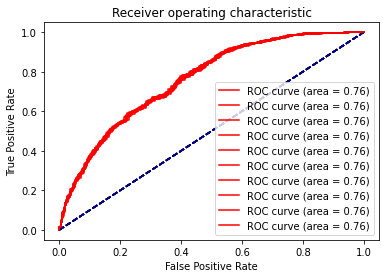

In [13]:

#y_bma_pred = []
predictions_bma = []
tp_bma = []
tn_bma = []
fn_bma = []
fp_bma = []
auc_bma_list = []
acc_bma_list = []
rec_pos = []
rec_neg = []
prec_pos = []
prec_neg = []
f1_pos = []
f1_neg = []
verit_assoluta = []
for j in range(0, 10):
    sum_prob0_bma =[]
    sum_prob1_bma =[]
    n_fold_tags = f"../data/results2strategy/tags/test/probs_test_fold_{j+1}_tags.csv"
    n_fold_text = f"../data/results2strategy/text/test/probs_test_{j+1}_text.csv"
    n_fold_caps = f"../data/results2strategy/caps/test/probs_test_fold_{j+1}_caps.csv"
    #data_probs = pd.read_csv(n_fold, sep="\t")
    probs_tags_test = pd.read_csv(n_fold_tags, sep="\t")
    probs_text_test = pd.read_csv(n_fold_text, sep="\t")
    probs_caps_test = pd.read_csv(n_fold_caps, sep="\t")
    #probs_tags_test.sort_values(by=['file_name'], ascending=True, inplace=True)
    #probs_text_test.sort_values(by=['file_name'], ascending=True, inplace=True)
    #probs_caps_test.sort_values(by=['file_name'], ascending=True, inplace=True)
 
    file_names_test = probs_tags_test["file_name"]
    y_test = probs_caps_test["GROUND TRUTH"]
    labels_bma = []
    y_prob_auc = []
    
    for i in range(0,1000):
        tags_prob0 = (probs_tags_test["SVM PROB 0"][i]* score_tags_test["SCORE 0 SVM"][j]) + (probs_tags_test["KNN PROB 0"][i]* score_tags_test["SCORE 0 KNN"][j])+ (probs_tags_test["NB PROB 0"][i]* score_tags_test["SCORE 0 NB"][j]) +  (probs_tags_test["DT PROB 0"][i]* score_tags_test["SCORE 0 DT"][j]) +  (probs_tags_test["MLP PROB 0"][i]* score_tags_test["SCORE 0 MLP"][j])
        text_prob0 = (probs_text_test["SVM PROB 0"][i]* score_text_test["SCORE 0 SVM"][j]) + (probs_text_test["KNN PROB 0"][i]* score_text_test["SCORE 0 KNN"][j])+ (probs_text_test["NB PROB 0"][i]* score_text_test["SCORE 0 NB"][j]) +  (probs_text_test["DT PROB 0"][i]* score_text_test["SCORE 0 DT"][j]) +  (probs_text_test["MLP PROB 0"][i]* score_text_test["SCORE 0 MLP"][j])
        caps_prob0 = (probs_caps_test["SVM PROB 0"][i]* score_caps_test["SCORE 0 SVM"][j]) + (probs_caps_test["KNN PROB 0"][i]* score_caps_test["SCORE 0 KNN"][j])+ (probs_caps_test["NB PROB 0"][i]* score_caps_test["SCORE 0 NB"][j]) +  (probs_caps_test["DT PROB 0"][i]* score_caps_test["SCORE 0 DT"][j]) +  (probs_caps_test["MLP PROB 0"][i]* score_caps_test["SCORE 0 MLP"][j])
        tags_prob1 = (probs_tags_test["SVM PROB 1"][i]* score_tags_test["SCORE 1 SVM"][j]) + (probs_tags_test["KNN PROB 1"][i]* score_tags_test["SCORE 1 KNN"][j])+ (probs_tags_test["NB PROB 1"][i]* score_tags_test["SCORE 1 NB"][j]) +  (probs_tags_test["DT PROB 1"][i]* score_tags_test["SCORE 1 DT"][j]) +  (probs_tags_test["MLP PROB 1"][i]* score_tags_test["SCORE 1 MLP"][j])
        text_prob1 = (probs_text_test["SVM PROB 1"][i]* score_text_test["SCORE 1 SVM"][j]) + (probs_text_test["KNN PROB 1"][i]* score_text_test["SCORE 1 KNN"][j])+ (probs_text_test["NB PROB 1"][i]* score_text_test["SCORE 1 NB"][j]) +  (probs_text_test["DT PROB 1"][i]* score_text_test["SCORE 1 DT"][j]) +  (probs_text_test["MLP PROB 1"][i]* score_text_test["SCORE 1 MLP"][j])
        caps_prob1 = (probs_caps_test["SVM PROB 1"][i]* score_caps_test["SCORE 1 SVM"][j]) + (probs_caps_test["KNN PROB 1"][i]* score_caps_test["SCORE 1 KNN"][j])+ (probs_caps_test["NB PROB 1"][i]* score_caps_test["SCORE 1 NB"][j]) +  (probs_caps_test["DT PROB 1"][i]* score_caps_test["SCORE 1 DT"][j]) +  (probs_caps_test["MLP PROB 1"][i]* score_caps_test["SCORE 1 MLP"][j])
        
        marginale_1_ = tags_prob1 + text_prob1 + caps_prob1
        marginale_0_ = tags_prob0 + text_prob0 + caps_prob0
        
        label_norm_0, label_norm_1 = normalize(marginale_0_,marginale_1_)
        sum_prob0_bma.append(label_norm_0)
        sum_prob1_bma.append(label_norm_1)
        #y_neg = nb_probs_neg[i] + svm_probs_neg[i] +rf_probs_neg[i]
        #y_pos = nb_probs_pos[i] +svm_probs_pos[i] +rf_probs_pos[i]
        y_prob_auc.append(marginale_1_)
        if label_norm_0 > label_norm_1:
        #if probs_sum_0[i] > probs_sum_1[i]:
          labels_bma.append(0)
        else:
          labels_bma.append(1)
        #if y_neg > y_pos:
        #  y_bma_pred.append(0)
        #else:
      #  y_bma_pred.append(1)
##########################
 
    
    #probs_name = f'../data/results2strategy/tags/sintest/probs_sin_test_fold_{j+1}_tags.csv'
    #data_probs.to_csv(probs_name, sep="\t")
    tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_test, labels_bma).ravel()
    tp_bma.append(tp_b)
    tn_bma.append(tn_b)
    fn_bma.append(fn_b)
    fp_bma.append(fp_b)
    rec_pos_bm = tp_b/ (tp_b + fn_b) ###True postive rate recall classe 1
    fn_rate_bm = fn_b/ (tp_b+ fn_b)
    prec_mis_bm =  tp_b/ (tp_b + fp_b)
    prec_notmis_bm = tn_b/ (tn_b + fn_b)
    rec_neg_bm = tn_b / (tn_b+ fp_b)
    f1_1_bm= (2* (prec_mis_bm * rec_pos_bm)) / (prec_mis_bm+ rec_pos_bm) 
    f1_0_bm = (2* (prec_notmis_bm * rec_neg_bm)) / (prec_notmis_bm + rec_neg_bm)
    false_positive_rate_bma = fp_b / (fp_b+ tn_b)
    rec_pos.append(rec_pos_bm) 
    rec_neg.append(rec_neg_bm) 
    f1_pos.append(f1_1_bm)   
    f1_neg.append(f1_0_bm)
    prec_pos.append(prec_mis_bm)
    prec_neg.append(prec_notmis_bm)
    
    print("f1 sklearn ", f1_score(y_test, labels_bma, average="macro"))
    print("prec sklearn ",precision_score(y_test, labels_bma, average="macro"))
    print("rec_sklearn", recall_score(y_test, labels_bma, average="macro")) 
    
    print("f1 1 mio ", f1_1_bm)
    print("f1 media mio ", mean([f1_0_bm, f1_1_bm]))
    print("prec mio ", prec_mis_bm)
    print("rec mio", rec_pos_bm) 
    print("prec media mio ", mean([prec_mis_bm, prec_notmis_bm]))
    print("rec media  mio", mean([rec_pos_bm, rec_neg_bm])) 
    fpr_bma, tpr_bma, thresholds_bma = roc_curve(y_test, y_prob_auc)
    roc_auc_bma = auc(fpr_bma, tpr_bma)
    
    printResult(labels_bma, y_prob_auc, y_test)
    auc_bma_list.append(roc_auc_bma)
    acc_bma = accuracy_score(y_test,labels_bma)
    print("ACC BMA ", acc_bma)
    print("AUC BMA ", roc_auc_bma)
    print("AUC SCORE ",metrics.roc_auc_score(y_test, y_prob_auc))
    acc_bma_list.append(acc_bma)
    predictions_bma.append(labels_bma)
    verit_assoluta.append(y_test)

    probs0_caps_svm = probs_caps_test["SVM PROB 0"]
    probs0_caps_knn = probs_caps_test["KNN PROB 0"]
    probs0_caps_mlp = probs_caps_test["MLP PROB 0"]
    probs0_caps_dtr = probs_caps_test["DT PROB 0"]
    probs0_caps_nb  = probs_caps_test["NB PROB 0"]
    probs1_caps_svm = probs_caps_test["SVM PROB 1"]
    probs1_caps_knn = probs_caps_test["KNN PROB 1"]
    probs1_caps_mlp = probs_caps_test["MLP PROB 1"]
    probs1_caps_dtr = probs_caps_test["DT PROB 1"]
    probs1_caps_nb  = probs_caps_test["NB PROB 1"]
    
    probs0_text_svm = probs_text_test["SVM PROB 0"]
    probs0_text_knn = probs_text_test["KNN PROB 0"]
    probs0_text_mlp = probs_text_test["MLP PROB 0"]
    probs0_text_dtr = probs_text_test["DT PROB 0"]
    probs0_text_nb  = probs_text_test["NB PROB 0"]
    probs1_text_svm = probs_text_test["SVM PROB 1"]
    probs1_text_knn = probs_text_test["KNN PROB 1"]
    probs1_text_mlp = probs_text_test["MLP PROB 1"]
    probs1_text_dtr = probs_text_test["DT PROB 1"]
    probs1_text_nb  = probs_text_test["NB PROB 1"]

    probs0_tags_svm = probs_tags_test["SVM PROB 0"]
    probs0_tags_knn = probs_tags_test["KNN PROB 0"]
    probs0_tags_mlp = probs_tags_test["MLP PROB 0"]
    probs0_tags_dtr = probs_tags_test["DT PROB 0"]
    probs0_tags_nb  = probs_tags_test["NB PROB 0"]
    probs1_tags_svm = probs_tags_test["SVM PROB 1"]
    probs1_tags_knn = probs_tags_test["KNN PROB 1"]
    probs1_tags_mlp = probs_tags_test["MLP PROB 1"]
    probs1_tags_dtr = probs_tags_test["DT PROB 1"]
    probs1_tags_nb  = probs_tags_test["NB PROB 1"]
    
    probs_test = {"file_name": file_names_test,
         "CAPS SVM PROB 0": [item for item in probs0_caps_svm], 
         "CAPS SVM PROB 1": [item for item in probs1_caps_svm], 
         "CAPS KNN PROB 0": [item for item in probs0_caps_knn], 
         "CAPS KNN PROB 1": [item for item in probs1_caps_knn],
         "CAPS NB PROB 0":  [item for item in probs0_caps_nb ],
         "CAPS NB PROB 1":  [item for item in probs1_caps_nb ], 
         "CAPS DT PROB 0":  [item for item in probs0_caps_dtr],
         "CAPS DT PROB 1":  [item for item in probs1_caps_dtr], 
         "CAPS MLP PROB 0": [item for item in probs0_caps_mlp],
         "CAPS MLP PROB 1": [item for item in probs1_caps_mlp], 
         "TAGS SVM PROB 0": [item for item in probs0_tags_svm], 
         "TAGS SVM PROB 1": [item for item in probs1_tags_svm], 
         "TAGS KNN PROB 0": [item for item in probs0_tags_knn], 
         "TAGS KNN PROB 1": [item for item in probs1_tags_knn],
         "TAGS NB PROB 0": [item for item in  probs0_tags_nb ],
         "TAGS NB PROB 1": [item for item in  probs1_tags_nb ], 
         "TAGS DT PROB 0": [item for item in  probs0_tags_dtr],
         "TAGS DT PROB 1": [item for item in  probs1_tags_dtr], 
         "TAGS MLP PROB 0": [item for item in probs0_tags_mlp],
         "TAGS MLP PROB 1": [item for item in probs1_tags_mlp],
         "TEXT SVM PROB 0": [item for item in probs0_text_svm], 
         "TEXT SVM PROB 1": [item for item in probs1_text_svm], 
         "TEXT KNN PROB 0": [item for item in probs0_text_knn], 
         "TEXT KNN PROB 1": [item for item in probs1_text_knn],
         "TEXT NB PROB 0":  [item for item in probs0_text_nb ],
         "TEXT NB PROB 1":  [item for item in probs1_text_nb ], 
         "TEXT DT PROB 0":  [item for item in probs0_text_dtr],
         "TEXT DT PROB 1":  [item for item in probs1_text_dtr], 
         "TEXT MLP PROB 0": [item for item in probs0_text_mlp],
         "TEXT MLP PROB 1": [item for item in probs1_text_mlp],
         "BMA PROB 0": [item for item in sum_prob0_bma],
         "BMA PROB 1": [item for item in sum_prob1_bma],
         "LABELS BMA": [item for item in predictions_bma[0]],
         "GROUND TRUTH": y_test
      }
    data_probs_test_clfs = pd.DataFrame(probs_test)
    nome_df_test = f"../data/results2strategy/bma/test/CLFS_PROBS_BMATOT_test_str2_fold_{j+1}.csv"
    data_probs_test_clfs.to_csv(nome_df_test, sep="\t")
#print("PROBS POS PER AUC ", y_prob_auc)
#tn, fp, fn, tp = confusion_matrix(y_test, y_bma_pred).ravel()
#print(tn,fp,fn,tp)
#true_postives_bma.append(tp)
#true_negatives_bma.append(tn)
#false_negative_bma.append(fn)
#false_positives_bma.append(fp)

#auc_score_bma = roc_auc_score(y_test, y_prob_auc)
verit_assoluta = [item for sublist in verit_assoluta for item in sublist]
predictions_bma = [item for sublist in predictions_bma for item in sublist]
print(confusion_matrix(verit_assoluta, predictions_bma ))
tn, fp, fn, tp = confusion_matrix(verit_assoluta, predictions_bma).ravel()
print(tn, fp, fn, tp)
cm = confusion_matrix(verit_assoluta, predictions_bma)
print(mean(tn_bma), mean(fp_bma), mean(fn_bma), mean(tp_bma))
#print("################  BMA calcolo alternativo #############################")
rec_pos_bma = sum(tp_bma)/ (sum(tp_bma) + sum(fn_bma)) ###True postive rate recall classe 1
fn_rate_bma = sum(fn_bma)/ (sum(tp_bma)+ sum(fn_bma))
prec_mis_bma = sum(tp_bma)/ (sum(tp_bma) + sum(fp_bma))
prec_notmis_bma = sum(tn_bma)/ (sum(tn_bma) + sum(fn_bma))
rec_neg_bma = sum(tn_bma) / (sum(tn_bma)+ sum(fp_bma))
false_positive_rate_bma = sum(fp_bma) / (sum(fp_bma)+ sum(tn_bma))
f1_1_bma= (2* (prec_mis_bma * rec_pos_bma)) / (prec_mis_bma+ rec_pos_bma) 
f1_0_bma = (2* (prec_notmis_bma * rec_neg_bma)) / (prec_notmis_bma + rec_neg_bma)



print("################  BMA #############################")
print("ACC BMA ", acc_bma_list)
print("ACC BMA ", sum(acc_bma_list)/10)
print("AUC BMA ", auc_bma_list)
print("AUC BMA ", sum(auc_bma_list)/10)

print("precision class 1 of k fold BMA ", prec_mis_bma)
print("precision class 0 of kfold BMA ", prec_notmis_bma)
print("prec ", mean([prec_mis_bma, prec_notmis_bma]))

print("recall class 1 k fold BMA", rec_pos_bma)
print("recall class 0 k fold BMA ", rec_neg_bma)
print("rec ", mean([rec_pos_bma, rec_neg_bma]))

print("f1 pos BMA ", f1_1_bma)
print("f1 neg BMA ", f1_0_bma)
print("f1 ", mean([f1_0_bma, f1_1_bma]))

[Text(0, 0.5, 'not misogynous'), Text(0, 1.5, 'misogynous')]

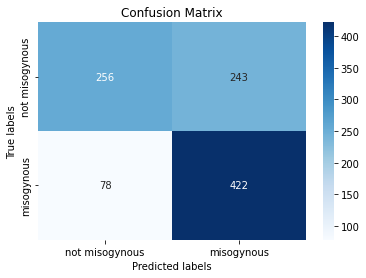

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()

sns.heatmap([[mean(tn_bma), mean(fp_bma)],[ mean(fn_bma), mean(tp_bma)]], annot=True, fmt='g', cmap="Blues", ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not misogynous', 'misogynous']); ax.yaxis.set_ticklabels(['not misogynous', 'misogynous'])

In [11]:
from statistics import mean
prec_bma = mean([prec_notmis_bma,prec_mis_bma])
rec_bma = mean([rec_neg_bma, rec_pos_bma])
f1_bma = mean([f1_0_bma, f1_1_bma])
acc_bma = sum(acc_bma_list)/10
roc_auc_bma =  sum(auc_bma_list)/10

In [16]:
res_test = {"Modelli": ["TAGS", "TEXT", "CAPS", "BMA"],
        "Prec 0": [ris_tags_test["Prec 0"][5], ris_text_test["Prec 0"][5], ris_caps_test["Prec 0"][5], prec_notmis_bma],
       "Prec 1": [ris_tags_test["Prec 1"][5], ris_text_test["Prec 1"][5], ris_caps_test["Prec 1"][5], prec_mis_bma],
       "Prec": [ris_tags_test["Prec"][5], ris_text_test["Prec"][5], ris_caps_test["Prec"][5], prec_bma],
       "Rec 0": [ris_tags_test["Rec 0"][5], ris_text_test["Rec 0"][5], ris_caps_test["Rec 0"][5], rec_neg_bma],
       "Rec 1": [ris_tags_test["Rec 1"][5], ris_text_test["Rec 1"][5], ris_caps_test["Rec 1"][5], rec_pos_bma],
       "Rec": [ris_tags_test["Rec"][5], ris_text_test["Rec"][5], ris_caps_test["Rec"][5],rec_bma],
       "F1 0": [ris_tags_test["F1 0"][5], ris_text_test["F1 0"][5], ris_caps_test["F1 0"][5], f1_0_bma],
       "F1 1": [ris_tags_test["F1 1"][5], ris_text_test["F1 1"][5], ris_caps_test["F1 1"][5], f1_1_bma], 
       "F1": [ris_tags_test["F1 "][5], ris_text_test["F1 "][5], ris_caps_test["F1 "][5], f1_bma], 
       "ACC": [ris_tags_test["ACC"][5], ris_text_test["ACC"][5], ris_caps_test["ACC"][5], acc_bma],
       "AUC": [ris_tags_test["AUC"][5], ris_text_test["AUC"][5], ris_caps_test["AUC"][5], roc_auc_bma]}

In [17]:
risultati_test = pd.DataFrame(res_test)
risultati_test

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.650800,0.609700,0.630300,0.5480,0.706,0.6270,0.595000,0.654300,0.624700,0.6270,0.687000
1,TEXT,0.714700,0.628800,0.671700,0.5360,0.786,0.6610,0.612600,0.698700,0.655600,0.6610,0.733400
2,CAPS,0.606600,0.589000,0.597800,0.5520,0.642,0.5970,0.578000,0.614400,0.596200,0.5970,0.643400
3,BMA,0.766607,0.633824,0.700215,0.5124,0.844,0.6782,0.614241,0.723966,0.669104,0.6782,0.760146


In [18]:
risultati_test.iloc[:,1:] = risultati_test.iloc[:,1:].round(4)
risultati_test

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.6508,0.6097,0.6303,0.5480,0.706,0.6270,0.5950,0.6543,0.6247,0.6270,0.6870
1,TEXT,0.7147,0.6288,0.6717,0.5360,0.786,0.6610,0.6126,0.6987,0.6556,0.6610,0.7334
2,CAPS,0.6066,0.5890,0.5978,0.5520,0.642,0.5970,0.5780,0.6144,0.5962,0.5970,0.6434
3,BMA,0.7666,0.6338,0.7002,0.5124,0.844,0.6782,0.6142,0.7240,0.6691,0.6782,0.7601


In [19]:
risultati_test.to_csv("../data/results2strategy/bma/test/BMA_RESULTS-test-803.csv", sep="\t")

In [38]:
risultati_test = pd.DataFrame(res_test)
risultati_test

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.650831,0.609672,0.630252,0.548,0.706,0.627,0.595005,0.654310,0.624657,0.627,0.687028
1,TEXT,0.714667,0.628800,0.671733,0.536,0.786,0.661,0.612571,0.698667,0.655619,0.661,0.733360
2,CAPS,0.606593,0.588991,0.597792,0.552,0.642,0.597,0.578010,0.614354,0.596182,0.597,0.643388
3,BMA,0.763636,0.629851,0.696744,0.504,0.844,0.674,0.607229,0.721368,0.664298,0.674,0.758520


#### CHECK RESULTS TEST

In [7]:
score = pd.read_csv("../data/results2strategy/bma/test/BMA_RESULTS-test-22-02.csv", sep="\t")
probs = pd.read_csv("../data/results2strategy/bma/test/CLFS_PROBS_BMATOT_test_str2_fold_1.csv", sep="\t")

In [8]:
probs

,Unnamed: 0,file_name,CAPS SVM PROB 0,CAPS SVM PROB 1,CAPS KNN PROB 0,CAPS KNN PROB 1,CAPS NB PROB 0,CAPS NB PROB 1,CAPS DT PROB 0,CAPS DT PROB 1,...,TEXT NB PROB 0,TEXT NB PROB 1,TEXT DT PROB 0,TEXT DT PROB 1,TEXT MLP PROB 0,TEXT MLP PROB 1,BMA PROB 0,BMA PROB 1,LABELS BMA,GROUND TRUTH
0,0,15236.jpg,0.633209,0.366791,0.714286,0.285714,0.541347,0.458653,0.661662,0.338338,...,9.255980e-04,0.999074,0.209445,0.790555,0.191855,0.808145,0.463263,0.536737,1,0
1,1,15805.jpg,0.214705,0.785295,0.571429,0.428571,0.062292,0.937708,0.174806,0.825194,...,3.859020e-09,1.000000,0.209445,0.790555,0.001469,0.998531,0.204589,0.795411,1,1
2,2,16254.jpg,0.684182,0.315818,0.571429,0.428571,0.970856,0.029144,0.661662,0.338338,...,3.643728e-05,0.999964,0.209445,0.790555,0.413663,0.586337,0.530338,0.469662,0,0
3,3,16191.jpg,0.685932,0.314068,0.857143,0.142857,0.978950,0.021050,0.661662,0.338338,...,1.012002e-04,0.999899,0.209445,0.790555,0.046010,0.953990,0.510928,0.489072,0,1
4,4,15952.jpg,0.348980,0.651020,0.571429,0.428571,0.032550,0.967450,0.666667,0.333333,...,2.784791e-05,0.999972,0.209445,0.790555,0.008879,0.991121,0.369518,0.630482,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,15591.jpg,0.190842,0.809158,0.142857,0.857143,0.001654,0.998346,0.174806,0.825194,...,5.094154e-06,0.999995,0.332155,0.667845,0.001681,0.998319,0.170026,0.829974,1,1
996,996,15049.jpg,0.207205,0.792795,0.000000,1.000000,0.016004,0.983996,0.174806,0.825194,...,8.757838e-05,0.999912,0.332155,0.667845,0.001373,0.998627,0.257660,0.742340,1,0
997,997,15363.jpg,0.177230,0.822770,0.428571,0.571429,0.013309,0.986691,0.174806,0.825194,...,3.985271e-11,1.000000,0.209445,0.790555,0.003042,0.996958,0.136798,0.863202,1,1
998,998,15199.jpg,0.693155,0.306845,0.571429,0.428571,0.921920,0.078080,0.661662,0.338338,...,1.597106e-04,0.999840,0.332155,0.667845,0.287095,0.712905,0.479548,0.520452,1,0


In [ ]:
j = 0
count = 0
probs0_text = []
probs0_tags = []
probs0_caps = []
probs1_text = []
probs1_tags = []
probs1_caps = []

labels_dt = []
labels_mlp = []
for i in range(0, 1000):
        #print(score["FOLD"][j])
        #print(i)
        marginale_0_ = (probs["CAPS PROB 0"][i]* score["F1 0"][2]) + (probs["TAGS PROB 0"][i]* score["F1 0"][0]) + (probs["TEXT PROB 0"][i]* score["F1 0"][1])
        marginale_1_ = (probs["CAPS PROB 1"][i]* score["F1 1"][2]) + (probs["TAGS PROB 1"][i]* score["F1 1"][0]) + (probs["TEXT PROB 1"][i]* score["F1 1"][1])
        marginale_0, marginale_1 = normalize(marginale_0_, marginale_1_)
        marginale_0 = round(marginale_0, 4)
        marginale_1 = round(marginale_1, 4)
        prob_bma0 = round(probs["BMA PROB 0"][i], 4)
        prob_bma1 = round(probs["BMA PROB 1"][i], 4)
        #print(marginale_0, prob_bma0)
        if marginale_0 != prob_bma0:
                print("calcolo sbagliato ", i)
                print(marginale_0, " != ", round(probs["BMA PROB 0"][i],4))
        if marginale_1 != prob_bma1:
                print("calcolo sbagliato ", i)
        if marginale_0 > marginale_1:
                label = 0
               #print(label)
        else:
                label = 1
        if label != probs["LABELS BMA"][i]:
                print(marginale_0, " ", marginale_1)
                print("LABEL ", label, " ground truth", probs["GROUND TRUTH"][i])
                print("LABEL NON CORRETTA " , i)
        #p0_svm = probs["SVM PROB 0"][i]  
        #p1_svm = probs["SVM PROB 1"][i]  
        #if p0_svm > p1_svm:
        #    label_svm = 0
        #else:
        #    label_svm = 1
        #p0_knn = probs["KNN PROB 0"][i]  
        #p1_knn = probs["KNN PROB 1"][i]  
        #if p0_knn > p1_knn:
        #    label_knn = 0
        #else:
        #    label_knn = 1
        #p0_dt = probs["DT PROB 0"][i]  
        #p1_dt = probs["DT PROB 1"][i]
        #if p0_dt > p1_dt:
        #    label_dt = 0
        #else:
        #    label_dt = 1
        #p0_nb = probs["NB PROB 0"][i]  
        #p1_nb = probs["NB PROB 1"][i]  
        #if p0_nb > p1_nb:
        #    label_nb = 0
        #else:
        #    label_nb = 1
#
        #p0_mlp = probs["MLP PROB 0"][i]  
        #p1_mlp = probs["MLP PROB 1"][i]  
        #if p0_mlp > p1_mlp:
        #    label_mlp = 0
        #else:
        #    label_mlp = 1
        #labels_svm.append(label_svm)
        #labels_knn.append(label_knn)
        #labels_dt.append(label_dt)
        #labels_nb.append(label_nb)
        #labels_mlp.append(label_mlp)
        #
        #if label_svm != probs["LABELS BMA"][i] and probs["LABELS BMA"][i] != probs["GROUND TRUTH"][i]:
        #    count +=1
        #    print("SVM-BMA label invertita index: ", i)
        #    print("LABEL SVM ", label_svm, " LABEL BMA ", probs["LABELS BMA"][i], " GROUND TRUTH ", probs["GROUND TRUTH"][i])
        #    if probs["LABELS BMA"][i] == 0:
        #        print("VOTO ", "SVM ", label_svm, " KNN ", label_knn, " DT ", label_dt, " NB ", label_nb, " MLP ", label_mlp)
        #        print("SVM(",probs["SVM PROB 0"][i], " * ", score["SCORE 0 SVM"][j], ") + KNN(",  probs["KNN PROB 0"][i], " * ", score["SCORE 0 KNN"][j], ") + NB(", probs["NB PROB 0"][i], " * ", score["SCORE 0 NB"][j],  ") + DT(" ,probs["DT PROB 0"][i], " * ",score["SCORE 0 DT"][j], ") + MLP(" ,probs["MLP PROB 0"][i]," * ",score["SCORE 0 MLP"][j] , ")= ", marginale_0)
        #    else:
         #       print("VOTO ", "SVM ", label_svm, " KNN ", label_knn, " DT ", label_dt, " NB ", label_nb, " MLP ", label_mlp)
         #       print("SVM (",probs["SVM PROB 1"][i], " * ", score["SCORE 1 SVM"][j], ") + KNN(",  probs["KNN PROB 1"][i], " * ", score["SCORE 1 KNN"][j], ") + NB(", probs["NB PROB 1"][i], " * ", score["SCORE 1 NB"][j],  ") + DT(" ,probs["DT PROB 1"][i], " * ",score["SCORE 1 DT"][j], ") + MLP(" ,probs["MLP PROB 1"][i]," * ",score["SCORE 1 MLP"][j] , ")= ", marginale_1)

print(count)

In [6]:
score

,Unnamed: 0,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,0,TAGS,0.6507,0.6100,0.6304,0.5492,0.7052,0.6272,0.5957,0.6542,0.6249,0.6272,0.6866
1,1,TEXT,0.7104,0.6288,0.6696,0.5396,0.7800,0.6598,0.6133,0.6963,0.6548,0.6598,0.7329
2,2,CAPS,0.6058,0.5882,0.5970,0.5510,0.6414,0.5962,0.5771,0.6137,0.5954,0.5962,0.6455
3,3,BMA,0.7666,0.6338,0.7002,0.5124,0.8440,0.6782,0.6142,0.7240,0.6691,0.6740,0.7595


In [7]:
probs_test

NameError: name 'probs_test' is not defined

In [10]:
    n_fold_tags = f"../data/results2strategy/tags/test/probs_test_fold_1_tags.csv"
    n_fold_text = f"../data/results2strategy/text/test/probs_test_1_text.csv"
    n_fold_caps = f"../data/results2strategy/caps/test/probs_test_fold_1_caps.csv"
    #data_probs = pd.read_csv(n_fold, sep="\t")
    probs_tags_test = pd.read_csv(n_fold_tags, sep="\t")
    probs_text_test = pd.read_csv(n_fold_text, sep="\t")
    probs_caps_test = pd.read_csv(n_fold_caps, sep="\t")

In [12]:
y_test = probs_caps_test["GROUND TRUTH"]

In [9]:
score_tags_test

,Unnamed: 0,FOLD,SCORE 0 SVM,SCORE 1 SVM,SCORE 0 KNN,SCORE 1 KNN,SCORE 0 NB,SCORE 1 NB,SCORE 0 DT,SCORE 1 DT,SCORE 0 MLP,SCORE 1 MLP
0,0,1,0.707340,0.677182,0.721254,0.624413,0.701051,0.671563,0.705036,0.630631,0.714015,0.680085
1,1,2,0.718356,0.675632,0.728916,0.624105,0.699387,0.661350,0.706144,0.623717,0.726091,0.680390
2,2,3,0.725016,0.681066,0.732102,0.634069,0.705994,0.670671,0.708876,0.624427,0.731542,0.685487
3,3,4,0.732192,0.684984,0.738116,0.640569,0.715997,0.676997,0.715281,0.615972,0.739770,0.689863
4,4,5,0.733097,0.690564,0.737679,0.640266,0.714313,0.677454,0.716652,0.618992,0.741685,0.695292
5,5,6,0.733499,0.692970,0.738212,0.644121,0.712488,0.676001,0.719454,0.622630,0.741746,0.696629
6,6,7,0.732428,0.696448,0.736121,0.644653,0.710394,0.677239,0.717150,0.619662,0.740564,0.698579
7,7,8,0.732179,0.697458,0.738240,0.647300,0.711481,0.680711,0.719060,0.621165,0.738756,0.697762
8,8,9,0.729037,0.698439,0.735480,0.647844,0.708998,0.681786,0.716709,0.624645,0.736403,0.698881
9,9,10,0.729988,0.696677,0.736907,0.648604,0.708254,0.679606,0.717350,0.619930,0.736793,0.696317


In [16]:
j = 0
count = 0
probs0_text = []
probs0_tags = []
probs0_caps = []
probs1_text = []
probs1_tags = []
probs1_caps = []

labels_dt = []
labels_mlp = []
for i in range(0, 1000):
        #print(score["FOLD"][j])
        #print(i)
        tags_prob0 = (probs_tags_test["SVM PROB 0"][i]* score_tags_test["SCORE 0 SVM"][j]) + (probs_tags_test["KNN PROB 0"][i]* score_tags_test["SCORE 0 KNN"][j])+ (probs_tags_test["NB PROB 0"][i]* score_tags_test["SCORE 0 NB"][j]) +  (probs_tags_test["DT PROB 0"][i]* score_tags_test["SCORE 0 DT"][j]) +  (probs_tags_test["MLP PROB 0"][i]* score_tags_test["SCORE 0 MLP"][j])
        text_prob0 = (probs_text_test["SVM PROB 0"][i]* score_text_test["SCORE 0 SVM"][j]) + (probs_text_test["KNN PROB 0"][i]* score_text_test["SCORE 0 KNN"][j])+ (probs_text_test["NB PROB 0"][i]* score_text_test["SCORE 0 NB"][j]) +  (probs_text_test["DT PROB 0"][i]* score_text_test["SCORE 0 DT"][j]) +  (probs_text_test["MLP PROB 0"][i]* score_text_test["SCORE 0 MLP"][j])
        caps_prob0 = (probs_caps_test["SVM PROB 0"][i]* score_caps_test["SCORE 0 SVM"][j]) + (probs_caps_test["KNN PROB 0"][i]* score_caps_test["SCORE 0 KNN"][j])+ (probs_caps_test["NB PROB 0"][i]* score_caps_test["SCORE 0 NB"][j]) +  (probs_caps_test["DT PROB 0"][i]* score_caps_test["SCORE 0 DT"][j]) +  (probs_caps_test["MLP PROB 0"][i]* score_caps_test["SCORE 0 MLP"][j])
        tags_prob1 = (probs_tags_test["SVM PROB 1"][i]* score_tags_test["SCORE 1 SVM"][j]) + (probs_tags_test["KNN PROB 1"][i]* score_tags_test["SCORE 1 KNN"][j])+ (probs_tags_test["NB PROB 1"][i]* score_tags_test["SCORE 1 NB"][j]) +  (probs_tags_test["DT PROB 1"][i]* score_tags_test["SCORE 1 DT"][j]) +  (probs_tags_test["MLP PROB 1"][i]* score_tags_test["SCORE 1 MLP"][j])
        text_prob1 = (probs_text_test["SVM PROB 1"][i]* score_text_test["SCORE 1 SVM"][j]) + (probs_text_test["KNN PROB 1"][i]* score_text_test["SCORE 1 KNN"][j])+ (probs_text_test["NB PROB 1"][i]* score_text_test["SCORE 1 NB"][j]) +  (probs_text_test["DT PROB 1"][i]* score_text_test["SCORE 1 DT"][j]) +  (probs_text_test["MLP PROB 1"][i]* score_text_test["SCORE 1 MLP"][j])
        caps_prob1 = (probs_caps_test["SVM PROB 1"][i]* score_caps_test["SCORE 1 SVM"][j]) + (probs_caps_test["KNN PROB 1"][i]* score_caps_test["SCORE 1 KNN"][j])+ (probs_caps_test["NB PROB 1"][i]* score_caps_test["SCORE 1 NB"][j]) +  (probs_caps_test["DT PROB 1"][i]* score_caps_test["SCORE 1 DT"][j]) +  (probs_caps_test["MLP PROB 1"][i]* score_caps_test["SCORE 1 MLP"][j])
        marginale_1_ = tags_prob1 + text_prob1 + caps_prob1
        marginale_0_ = tags_prob0 + text_prob0 + caps_prob0

        text_vote_0, text_vote_1 = normalize(text_prob0, text_prob1)
        caps_vote_0, caps_vote_1 = normalize(caps_prob0, caps_prob1)
        tags_vote_0, tags_vote_1 = normalize(tags_prob0, tags_prob1)
        marginale_0, marginale_1 = normalize(marginale_0_, marginale_1_)
        
        if marginale_0 > marginale_1:
                label_bma = 0
        else:
                label_bma = 1
        
        if text_vote_0 > text_vote_1:
                text_label = 0
        else:
                text_label = 1
        if caps_vote_0 > caps_vote_1:
                caps_label = 0
        else:
                caps_label = 1
        if tags_vote_0 > tags_vote_1:
                tags_label = 0
        else:
                tags_label = 1
        
        if text_label == label_bma  and tags_label!= label_bma and caps_label != label_bma and label_bma == y_test[i]:
                print(probs_caps_test["file_name"][i])
                print(label_bma, text_label, caps_label, tags_label)
                count +=1
                
        #print(marginale_0, prob_bma0)
        #if marginale_0 != prob_bma0:
        #        print("calcolo sbagliato ", i)
        #        print(marginale_0, " != ", round(probs["BMA PROB 0"][i],4))
        #if marginale_1 != prob_bma1:
        #        print("calcolo sbagliato ", i)
        #if marginale_0 > marginale_1:
        #        label = 0
        #       #print(label)
        #else:
        #        label = 1
        #if label != probs["LABELS BMA"][i]:
        #        print(marginale_0, " ", marginale_1)
        #        print("LABEL ", label, " ground truth", probs["GROUND TRUTH"][i])
        #        print("LABEL NON CORRETTA " , i)
        #p0_svm = probs["SVM PROB 0"][i]  
        #p1_svm = probs["SVM PROB 1"][i]  
        #if p0_svm > p1_svm:
        #    label_svm = 0
        #else:
        #    label_svm = 1
        #p0_knn = probs["KNN PROB 0"][i]  
        #p1_knn = probs["KNN PROB 1"][i]  
        #if p0_knn > p1_knn:
        #    label_knn = 0
        #else:
        #    label_knn = 1
        #p0_dt = probs["DT PROB 0"][i]  
        #p1_dt = probs["DT PROB 1"][i]
        #if p0_dt > p1_dt:
        #    label_dt = 0
        #else:
        #    label_dt = 1
        #p0_nb = probs["NB PROB 0"][i]  
        #p1_nb = probs["NB PROB 1"][i]  
        #if p0_nb > p1_nb:
        #    label_nb = 0
        #else:
        #    label_nb = 1
#
        #p0_mlp = probs["MLP PROB 0"][i]  
        #p1_mlp = probs["MLP PROB 1"][i]  
        #if p0_mlp > p1_mlp:
        #    label_mlp = 0
        #else:
        #    label_mlp = 1
        #labels_svm.append(label_svm)
        #labels_knn.append(label_knn)
        #labels_dt.append(label_dt)
        #labels_nb.append(label_nb)
        #labels_mlp.append(label_mlp)
        #
        #if label_svm != probs["LABELS BMA"][i] and probs["LABELS BMA"][i] != probs["GROUND TRUTH"][i]:
        #    count +=1
        #    print("SVM-BMA label invertita index: ", i)
        #    print("LABEL SVM ", label_svm, " LABEL BMA ", probs["LABELS BMA"][i], " GROUND TRUTH ", probs["GROUND TRUTH"][i])
        #    if probs["LABELS BMA"][i] == 0:
        #        print("VOTO ", "SVM ", label_svm, " KNN ", label_knn, " DT ", label_dt, " NB ", label_nb, " MLP ", label_mlp)
        #        print("SVM(",probs["SVM PROB 0"][i], " * ", score["SCORE 0 SVM"][j], ") + KNN(",  probs["KNN PROB 0"][i], " * ", score["SCORE 0 KNN"][j], ") + NB(", probs["NB PROB 0"][i], " * ", score["SCORE 0 NB"][j],  ") + DT(" ,probs["DT PROB 0"][i], " * ",score["SCORE 0 DT"][j], ") + MLP(" ,probs["MLP PROB 0"][i]," * ",score["SCORE 0 MLP"][j] , ")= ", marginale_0)
        #    else:
         #       print("VOTO ", "SVM ", label_svm, " KNN ", label_knn, " DT ", label_dt, " NB ", label_nb, " MLP ", label_mlp)
         #       print("SVM (",probs["SVM PROB 1"][i], " * ", score["SCORE 1 SVM"][j], ") + KNN(",  probs["KNN PROB 1"][i], " * ", score["SCORE 1 KNN"][j], ") + NB(", probs["NB PROB 1"][i], " * ", score["SCORE 1 NB"][j],  ") + DT(" ,probs["DT PROB 1"][i], " * ",score["SCORE 1 DT"][j], ") + MLP(" ,probs["MLP PROB 1"][i]," * ",score["SCORE 1 MLP"][j] , ")= ", marginale_1)

print(count)

15560.jpg
0 0 1 1
16056.jpg
0 0 1 1
16165.jpg
1 1 0 0
17018.jpg
1 1 0 0
15504.jpg
1 1 0 0
15659.jpg
1 1 0 0
16124.jpg
1 1 0 0
15051.jpg
1 1 0 0
16127.jpg
1 1 0 0
15281.jpg
1 1 0 0
16067.jpg
1 1 0 0
15667.jpg
1 1 0 0
15112.jpg
1 1 0 0
17046.jpg
1 1 0 0
15771.jpg
1 1 0 0
15911.jpg
1 1 0 0
15211.jpg
1 1 0 0
15113.jpg
1 1 0 0
16256.jpg
1 1 0 0
15468.jpg
1 1 0 0
15700.jpg
0 0 1 1
15898.jpg
1 1 0 0
15102.jpg
1 1 0 0
15524.jpg
0 0 1 1
16258.jpg
1 1 0 0
15425.jpg
1 1 0 0
16119.jpg
1 1 0 0
16251.jpg
1 1 0 0
17029.jpg
1 1 0 0
15766.jpg
1 1 0 0
15442.jpg
1 1 0 0
17075.jpg
1 1 0 0
15989.jpg
0 0 1 1
15653.jpg
0 0 1 1
15498.jpg
1 1 0 0
15050.jpg
1 1 0 0
15202.jpg
1 1 0 0
15143.jpg
1 1 0 0
15714.jpg
1 1 0 0
15699.jpg
0 0 1 1
15257.jpg
1 1 0 0
15088.jpg
1 1 0 0
15901.jpg
1 1 0 0
16078.jpg
1 1 0 0
15937.jpg
1 1 0 0
16307.jpg
1 1 0 0
15473.jpg
1 1 0 0
15240.jpg
1 1 0 0
16309.jpg
1 1 0 0
15578.jpg
0 0 1 1
15854.jpg
1 1 0 0
17079.jpg
1 1 0 0
16324.jpg
1 1 0 0
15241.jpg
0 0 1 1
15598.jpg
1 1 0 0
15987.jpg


### Sinthetic Test

In [18]:
probs_tags_sintest = pd.read_csv("../data/results/sin_test/tags_probs_sin_test1902.csv", sep="\t")
probs_text_sintest = pd.read_csv("../data/results/sin_test/text_probs_bma_sin_test2102.csv", sep="\t")
probs_caps_sintest = pd.read_csv("../data/results/sin_test/caps_probs_bma_sin_test1902.csv", sep="\t")

In [19]:
score_text_test = pd.read_csv("../data/results2strategy/text/sintest/score_sin_test_text10fold.csv", sep="\t")
score_caps_test = pd.read_csv("../data/results2strategy/caps/sintest/score_sin_test_caps10fold.csv", sep="\t")
score_tags_test = pd.read_csv("../data/results2strategy/tags/sintest/score_sin_test_tags10fold.csv", sep="\t")

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [ ]:
evaluation_metrics.printResult
evaluation_metrics.normalize

Accuracy: 74.00

Confusion Matrix:
 [[51 24]
 [15 60]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        75
           1       0.71      0.80      0.75        75

    accuracy                           0.74       150
   macro avg       0.74      0.74      0.74       150
weighted avg       0.74      0.74      0.74       150

Area under the ROC curve : 0.810667
ACC BMA  0.74
AUC BMA  0.8106666666666666
Accuracy: 75.33

Confusion Matrix:
 [[54 21]
 [16 59]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        75
           1       0.74      0.79      0.76        75

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.75      0.75      0.75       150

Area under the ROC curve : 0.814756
ACC BMA  0.7533333333333333
AUC BMA  0.8147555555555556
Accuracy: 74.67

Confusion Matrix:
 [[52 23]
 [15 60]]
           

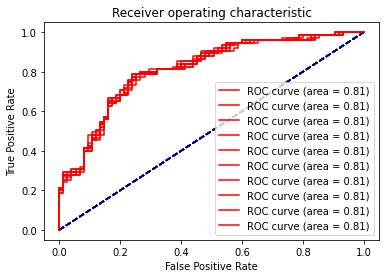

In [22]:

#y_bma_pred = []
predictions_bma = []
tp_bma = []
tn_bma = []
fn_bma = []
fp_bma = []
auc_bma_list = []
acc_bma_list = []
rec_pos = []
rec_neg = []
prec_pos = []
prec_neg = []
f1_pos = []
f1_neg = []

for j in range(0, 10):
    sum_prob0_bma =[]
    sum_prob1_bma =[]
    n_fold_tags = f"../data/results2strategy/tags/sintest/probs_sin_test_fold_{j+1}_tags.csv"
    n_fold_text = f"../data/results2strategy/text/sintest/probs_sin_test_fold_{j+1}_text.csv"
    n_fold_caps = f"../data/results2strategy/caps/sintest/probs_sin_test_fold_{j+1}_caps.csv"
    #data_probs = pd.read_csv(n_fold, sep="\t")
    probs_tags_test = pd.read_csv(n_fold_tags, sep="\t")
    probs_text_test = pd.read_csv(n_fold_text, sep="\t")
    probs_caps_test = pd.read_csv(n_fold_caps, sep="\t")
    #probs_tags_test.sort_values(by=['file_name'], ascending=True, inplace=True)
    #probs_text_test.sort_values(by=['file_name'], ascending=True, inplace=True)
    #probs_caps_test.sort_values(by=['file_name'], ascending=True, inplace=True)
 
    file_names_test = probs_tags_test["file_name"]
    y_test = probs_caps_test["GROUND TRUTH"]
    labels_bma = []
    y_prob_auc = []
    
    for i in range(0,150):
      
        tags_prob0 = (probs_tags_test["SVM PROB 0"][i]* score_tags_test["SCORE 0 SVM"][j]) + (probs_tags_test["KNN PROB 0"][i]* score_tags_test["SCORE 0 KNN"][j])+ (probs_tags_test["NB PROB 0"][i]* score_tags_test["SCORE 0 NB"][j]) +  (probs_tags_test["DT PROB 0"][i]* score_tags_test["SCORE 0 DT"][j]) +  (probs_tags_test["MLP PROB 0"][i]* score_tags_test["SCORE 0 MLP"][j])
        text_prob0 = (probs_text_test["SVM PROB 0"][i]* score_text_test["SCORE 0 SVM"][j]) + (probs_text_test["KNN PROB 0"][i]* score_text_test["SCORE 0 KNN"][j])+ (probs_text_test["NB PROB 0"][i]* score_text_test["SCORE 0 NB"][j]) +  (probs_text_test["DT PROB 0"][i]* score_text_test["SCORE 0 DT"][j]) +  (probs_text_test["MLP PROB 0"][i]* score_text_test["SCORE 0 MLP"][j])
        caps_prob0 = (probs_caps_test["SVM PROB 0"][i]* score_caps_test["SCORE 0 SVM"][j]) + (probs_caps_test["KNN PROB 0"][i]* score_caps_test["SCORE 0 KNN"][j])+ (probs_caps_test["NB PROB 0"][i]* score_caps_test["SCORE 0 NB"][j]) +  (probs_caps_test["DT PROB 0"][i]* score_caps_test["SCORE 0 DT"][j]) +  (probs_caps_test["MLP PROB 0"][i]* score_caps_test["SCORE 0 MLP"][j])
        tags_prob1 = (probs_tags_test["SVM PROB 1"][i]* score_tags_test["SCORE 1 SVM"][j]) + (probs_tags_test["KNN PROB 1"][i]* score_tags_test["SCORE 1 KNN"][j])+ (probs_tags_test["NB PROB 1"][i]* score_tags_test["SCORE 1 NB"][j]) +  (probs_tags_test["DT PROB 1"][i]* score_tags_test["SCORE 1 DT"][j]) +  (probs_tags_test["MLP PROB 1"][i]* score_tags_test["SCORE 1 MLP"][j])
        text_prob1 = (probs_text_test["SVM PROB 1"][i]* score_text_test["SCORE 1 SVM"][j]) + (probs_text_test["KNN PROB 1"][i]* score_text_test["SCORE 1 KNN"][j])+ (probs_text_test["NB PROB 1"][i]* score_text_test["SCORE 1 NB"][j]) +  (probs_text_test["DT PROB 1"][i]* score_text_test["SCORE 1 DT"][j]) +  (probs_text_test["MLP PROB 1"][i]* score_text_test["SCORE 1 MLP"][j])
        caps_prob1 = (probs_caps_test["SVM PROB 1"][i]* score_caps_test["SCORE 1 SVM"][j]) + (probs_caps_test["KNN PROB 1"][i]* score_caps_test["SCORE 1 KNN"][j])+ (probs_caps_test["NB PROB 1"][i]* score_caps_test["SCORE 1 NB"][j]) +  (probs_caps_test["DT PROB 1"][i]* score_caps_test["SCORE 1 DT"][j]) +  (probs_caps_test["MLP PROB 1"][i]* score_caps_test["SCORE 1 MLP"][j])
        
        marginale_1_ = tags_prob1 + text_prob1 + caps_prob1
        marginale_0_ = tags_prob0 + text_prob0 + caps_prob0
        
        label_norm_0, label_norm_1 = evaluation_metrics.normalize(marginale_0_,marginale_1_)
        sum_prob0_bma.append(label_norm_0)
        sum_prob1_bma.append(label_norm_1)
        #y_neg = nb_probs_neg[i] + svm_probs_neg[i] +rf_probs_neg[i]
        #y_pos = nb_probs_pos[i] +svm_probs_pos[i] +rf_probs_pos[i]
        y_prob_auc.append(marginale_1_)
        if label_norm_0 > label_norm_1:
        #if probs_sum_0[i] > probs_sum_1[i]:
          labels_bma.append(0)
        else:
          labels_bma.append(1)
        #if y_neg > y_pos:
        #  y_bma_pred.append(0)
        #else:
      #  y_bma_pred.append(1)
##########################
 
    
    #probs_name = f'../data/results2strategy/tags/sintest/probs_sin_test_fold_{j+1}_tags.csv'
    #data_probs.to_csv(probs_name, sep="\t")
    tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_test, labels_bma).ravel()
    tp_bma.append(tp_b)
    tn_bma.append(tn_b)
    fn_bma.append(fn_b)
    fp_bma.append(fp_b)
    rec_pos_bm = tp_b/ (tp_b + fn_b) ###True postive rate recall classe 1
    fn_rate_bm = fn_b/ (tp_b+ fn_b)
    prec_mis_bm =  tp_b/ (tp_b + fp_b)
    prec_notmis_bm = tn_b/ (tn_b + fn_b)
    rec_neg_bm = tn_b / (tn_b+ fp_b)
    f1_1_bm= (2* (prec_mis_bm * rec_pos_bm)) / (prec_mis_bm+ rec_pos_bm) 
    f1_0_bm = (2* (prec_notmis_bm * rec_neg_bm)) / (prec_notmis_bm + rec_neg_bm)
    false_positive_rate_bma = fp_b / (fp_b+ tn_b)
    rec_pos.append(rec_pos_bm) 
    rec_neg.append(rec_neg_bm) 
    f1_pos.append(f1_1_bm)   
    f1_neg.append(f1_0_bm)
    prec_pos.append(prec_mis_bm)
    prec_neg.append(prec_notmis_bm)
    
    fpr_bma, tpr_bma, thresholds_bma = roc_curve(y_test, y_prob_auc)
    roc_auc_bma = auc(fpr_bma, tpr_bma)
    evaluation_metrics.printResult(labels_bma, y_prob_auc, y_test)
    auc_bma_list.append(roc_auc_bma)
    acc_bma = accuracy_score(y_test,labels_bma)
    print("ACC BMA ", acc_bma)
    print("AUC BMA ", roc_auc_bma)
    acc_bma_list.append(acc_bma)
    predictions_bma.append(labels_bma)
  
    probs0_caps_svm = probs_caps_test["SVM PROB 0"]
    probs0_caps_knn = probs_caps_test["KNN PROB 0"]
    probs0_caps_mlp = probs_caps_test["MLP PROB 0"]
    probs0_caps_dtr = probs_caps_test["DT PROB 0"]
    probs0_caps_nb  = probs_caps_test["NB PROB 0"]
    probs1_caps_svm = probs_caps_test["SVM PROB 1"]
    probs1_caps_knn = probs_caps_test["KNN PROB 1"]
    probs1_caps_mlp = probs_caps_test["MLP PROB 1"]
    probs1_caps_dtr = probs_caps_test["DT PROB 1"]
    probs1_caps_nb  = probs_caps_test["NB PROB 1"]
    
    probs0_text_svm = probs_text_test["SVM PROB 0"]
    probs0_text_knn = probs_text_test["KNN PROB 0"]
    probs0_text_mlp = probs_text_test["MLP PROB 0"]
    probs0_text_dtr = probs_text_test["DT PROB 0"]
    probs0_text_nb  = probs_text_test["NB PROB 0"]
    
    probs1_text_svm = probs_text_test["SVM PROB 1"]
    probs1_text_knn = probs_text_test["KNN PROB 1"]
    probs1_text_mlp = probs_text_test["MLP PROB 1"]
    probs1_text_dtr = probs_text_test["DT PROB 1"]
    probs1_text_nb  = probs_text_test["NB PROB 1"]

    probs0_tags_svm = probs_tags_test["SVM PROB 0"]
    probs0_tags_knn = probs_tags_test["KNN PROB 0"]
    probs0_tags_mlp = probs_tags_test["MLP PROB 0"]
    probs0_tags_dtr = probs_tags_test["DT PROB 0"]
    probs0_tags_nb  = probs_tags_test["NB PROB 0"]
    probs1_tags_svm = probs_tags_test["SVM PROB 1"]
    probs1_tags_knn = probs_tags_test["KNN PROB 1"]
    probs1_tags_mlp = probs_tags_test["MLP PROB 1"]
    probs1_tags_dtr = probs_tags_test["DT PROB 1"]
    probs1_tags_nb  = probs_tags_test["NB PROB 1"]
    
    probs_test = {"file_name": file_names_test,
         "CAPS SVM PROB 0": [item for item in probs0_caps_svm], 
         "CAPS SVM PROB 1": [item for item in probs1_caps_svm], 
         "CAPS KNN PROB 0": [item for item in probs0_caps_knn], 
         "CAPS KNN PROB 1": [item for item in probs1_caps_knn],
         "CAPS NB PROB 0":  [item for item in probs0_caps_nb ],
         "CAPS NB PROB 1":  [item for item in probs1_caps_nb ], 
         "CAPS DT PROB 0":  [item for item in probs0_caps_dtr],
         "CAPS DT PROB 1":  [item for item in probs1_caps_dtr], 
         "CAPS MLP PROB 0": [item for item in probs0_caps_mlp],
         "CAPS MLP PROB 1": [item for item in probs1_caps_mlp], 
         "TAGS SVM PROB 0": [item for item in probs0_tags_svm], 
         "TAGS SVM PROB 1": [item for item in probs1_tags_svm], 
         "TAGS KNN PROB 0": [item for item in probs0_tags_knn], 
         "TAGS KNN PROB 1": [item for item in probs1_tags_knn],
         "TAGS NB PROB 0": [item for item in  probs0_tags_nb ],
         "TAGS NB PROB 1": [item for item in  probs1_tags_nb ], 
         "TAGS DT PROB 0": [item for item in  probs0_tags_dtr],
         "TAGS DT PROB 1": [item for item in  probs1_tags_dtr], 
         "TAGS MLP PROB 0": [item for item in probs0_tags_mlp],
         "TAGS MLP PROB 1": [item for item in probs1_tags_mlp],
         "TEXT SVM PROB 0": [item for item in probs0_text_svm], 
         "TEXT SVM PROB 1": [item for item in probs1_text_svm], 
         "TEXT KNN PROB 0": [item for item in probs0_text_knn], 
         "TEXT KNN PROB 1": [item for item in probs1_text_knn],
         "TEXT NB PROB 0":  [item for item in probs0_text_nb ],
         "TEXT NB PROB 1":  [item for item in probs1_text_nb ], 
         "TEXT DT PROB 0":  [item for item in probs0_text_dtr],
         "TEXT DT PROB 1":  [item for item in probs1_text_dtr], 
         "TEXT MLP PROB 0": [item for item in probs0_text_mlp],
         "TEXT MLP PROB 1": [item for item in probs1_text_mlp],
         "BMA PROB 0": [item for item in sum_prob0_bma],
         "BMA PROB 1": [item for item in sum_prob1_bma],
         "LABELS BMA": [item for item in predictions_bma[0]],
         "GROUND TRUTH": y_test
      }
    data_probs_test_clfs = pd.DataFrame(probs_test)
    nome_df_test = f"../data/results2strategy/bma/sintest/CLFS_PROBS_BMATOT_sintest_str2_fold_{j+1}.csv"
    data_probs_test_clfs.to_csv(nome_df_test, sep="\t")
#print("PROBS POS PER AUC ", y_prob_auc)
#tn, fp, fn, tp = confusion_matrix(y_test, y_bma_pred).ravel()
#print(tn,fp,fn,tp)
#true_postives_bma.append(tp)
#true_negatives_bma.append(tn)
#false_negative_bma.append(fn)
#false_positives_bma.append(fp)

#auc_score_bma = roc_auc_score(y_test, y_prob_auc)

#print("################  BMA calcolo alternativo #############################")
rec_pos_bma = sum(tp_bma)/ (sum(tp_bma) + sum(fn_bma)) ###True postive rate recall classe 1
fn_rate_bma = sum(fn_bma)/ (sum(tp_bma)+ sum(fn_bma))
prec_mis_bma = sum(tp_bma)/ (sum(tp_bma) + sum(fp_bma))
prec_notmis_bma = sum(tn_bma)/ (sum(tn_bma) + sum(fn_bma))
rec_neg_bma = sum(tn_bma) / (sum(tn_bma)+ sum(fp_bma))
false_positive_rate_bma = sum(fp_bma) / (sum(fp_bma)+ sum(tn_bma))
f1_1_bma= (2* (prec_mis_bma * rec_pos_bma)) / (prec_mis_bma+ rec_pos_bma) 
f1_0_bma = (2* (prec_notmis_bma * rec_neg_bma)) / (prec_notmis_bma + rec_neg_bma)


print("################  BMA #############################")
print("ACC BMA ", acc_bma_list)
print("ACC BMA ", sum(acc_bma_list)/10)
print("AUC BMA ", auc_bma_list)
print("AUC BMA ", sum(auc_bma_list)/10)

print("precision class 1 of k fold BMA ", prec_mis_bma)
print("precision class 0 of kfold BMA ", prec_notmis_bma)
print("prec ", mean([prec_mis_bma, prec_notmis_bma]))

print("recall class 1 k fold BMA", rec_pos_bma)
print("recall class 0 k fold BMA ", rec_neg_bma)
print("rec ", mean([rec_pos_bma, rec_neg_bma]))

print("f1 pos BMA ", f1_1_bma)
print("f1 neg BMA ", f1_0_bma)
print("f1 ", mean([f1_0_bma, f1_1_bma]))

In [23]:
from statistics import mean
prec_bma = mean([prec_notmis_bma,prec_mis_bma])
rec_bma = mean([rec_neg_bma, rec_pos_bma])
f1_bma = mean([f1_0_bma, f1_1_bma])
acc_bma = sum(acc_bma_list)/10
auc_bma = sum(auc_bma_list)/10


In [24]:
res_sintest = {"Modelli": ["TAGS", "TEXT", "CAPS", "BMA"],
        "Prec 0": [ris_tags_sintest["Prec 0"][5], ris_text_sintest["Prec 0"][5], ris_caps_sintest["Prec 0"][5], prec_notmis_bma],
       "Prec 1": [ris_tags_sintest["Prec 1"][5], ris_text_sintest["Prec 1"][5], ris_caps_sintest["Prec 1"][5], prec_mis_bma],
       "Prec": [ris_tags_sintest["Prec"][5], ris_text_sintest["Prec"][5], ris_caps_sintest["Prec"][5], prec_bma],
       "Rec 0": [ris_tags_sintest["Rec 0"][5], ris_text_sintest["Rec 0"][5], ris_caps_sintest["Rec 0"][5], rec_neg_bma],
       "Rec 1": [ris_tags_sintest["Rec 1"][5], ris_text_sintest["Rec 1"][5], ris_caps_sintest["Rec 1"][5], rec_pos_bma],
       "Rec": [ris_tags_sintest["Rec"][5], ris_text_sintest["Rec"][5], ris_caps_sintest["Rec"][5],rec_bma],
       "F1 0": [ris_tags_sintest["F1 0"][5], ris_text_sintest["F1 0"][5], ris_caps_sintest["F1 0"][5], f1_0_bma],
       "F1 1": [ris_tags_sintest["F1 1"][5], ris_text_sintest["F1 1"][5], ris_caps_sintest["F1 1"][5], f1_1_bma], 
       "F1": [ris_tags_sintest["F1 "][5], ris_text_sintest["F1 "][5], ris_caps_sintest["F1 "][5], f1_bma], 
       "ACC": [ris_tags_sintest["ACC"][5], ris_text_sintest["ACC"][5], ris_caps_sintest["ACC"][5], acc_bma],
       "AUC": [ris_tags_sintest["AUC"][5], ris_text_sintest["AUC"][5], ris_caps_sintest["AUC"][5], roc_auc_bma]}

NameError: name 'ris_tags_sintest' is not defined

In [17]:
risultati_sintest = pd.DataFrame(res_sintest)
risultati_sintest

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.715268,0.702458,0.708863,0.693333,0.724000,0.708667,0.704130,0.713066,0.708598,0.708667,0.734222
1,TEXT,0.676096,0.656999,0.666547,0.637333,0.694667,0.666000,0.656143,0.675308,0.665725,0.666000,0.705422
2,CAPS,0.667082,0.691977,0.679530,0.713333,0.644000,0.678667,0.689433,0.667127,0.678280,0.678667,0.730489
3,BMA,0.772263,0.728834,0.750549,0.705333,0.792000,0.748667,0.737282,0.759105,0.748194,0.748667,0.812089


In [18]:
risultati_sintest.iloc[:,1:] = risultati_sintest.iloc[:,1:].round(4)
risultati_sintest

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.7153,0.7025,0.7089,0.6933,0.7240,0.7087,0.7041,0.7131,0.7086,0.7087,0.7342
1,TEXT,0.6761,0.6570,0.6665,0.6373,0.6947,0.6660,0.6561,0.6753,0.6657,0.6660,0.7054
2,CAPS,0.6671,0.6920,0.6795,0.7133,0.6440,0.6787,0.6894,0.6671,0.6783,0.6787,0.7305
3,BMA,0.7723,0.7288,0.7505,0.7053,0.7920,0.7487,0.7373,0.7591,0.7482,0.7487,0.8121


In [45]:
risultati_sintest = pd.DataFrame(res_sintest)
risultati_sintest

,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,TAGS,0.715268,0.702458,0.708863,0.693333,0.724000,0.708667,0.704130,0.713066,0.708598,0.708667,0.734222
1,TEXT,0.676096,0.656999,0.666547,0.637333,0.694667,0.666000,0.656143,0.675308,0.665725,0.666000,0.705422
2,CAPS,0.667082,0.691977,0.679530,0.713333,0.644000,0.678667,0.689433,0.667127,0.678280,0.678667,0.730489
3,BMA,0.773775,0.735732,0.754754,0.716000,0.790667,0.753333,0.743767,0.762211,0.752989,0.753333,0.812444


In [19]:

risultati_sintest.to_csv("../data/results2strategy/bma/sintest/BMA_RESULTS-sintest-22-02.csv", sep="\t")

In [ ]:
riis_train = pd.read_csv("BMA_RESULTS-train-19-02.csv", sep="\t")
riis_test = pd.read_csv("BMA_RESULTS-test-19-02.csv", sep="\t")
riis_sintest = pd.read_csv("BMA_RESULTS-sintest-19-02.csv", sep="\t")

In [ ]:
riis_test.iloc[:,2:] = riis_test.iloc[:,2:].round(4)
riis_test.to_csv("../data/results/BMA_RESULTS-test-19-02.csv", sep="\t")

In [ ]:
riis_sintest.iloc[:,2:] = riis_sintest.iloc[:,2:].round(4)
riis_sintest.to_csv("../data/results/BMA_RESULTS-sintest-19-02.csv", sep="\t")

In [ ]:
riis_train

,Unnamed: 0,Modelli,Prec 0,Prec 1,Prec,Rec 0,Rec 1,Rec,F1 0,F1 1,F1,ACC,AUC
0,0,TAGS,0.6541,0.7126,0.6834,0.7584,0.5990,0.6787,0.7024,0.6509,0.6766,0.6787,0.7269
1,1,TEXT,0.7899,0.7959,0.7929,0.7980,0.7878,0.7929,0.7940,0.7918,0.7929,0.7929,0.8753
2,2,CAPS,0.6562,0.7695,0.7129,0.8308,0.5648,0.6978,0.7333,0.6514,0.6924,0.6978,0.7557
3,3,BMA,0.7624,0.8418,0.8021,0.8626,0.7312,0.7969,0.8094,0.7826,0.7960,0.7969,0.8997


In [ ]:
riis_train.iloc[:,2:] = riis_train.iloc[:,2:].round(4)

### CM SYNTEST

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

PEFFOMMANCE rec 0.8 prec  0.7142857142857143 f1  0.7547169811320756 acc  0.74
1500


[Text(0, 0.5, 'not misogynous'), Text(0, 1.5, 'misogynous')]

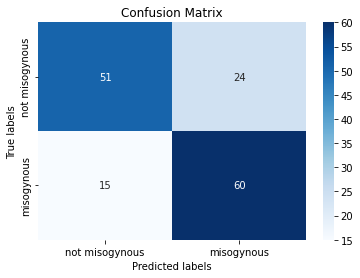

In [5]:
tn_bma = []
fp_bma = []
fn_bma = []
tp_bma = []
acc = []
rec = []
prec = []
f1 = []

for j in range(0,10):
    n_fold = f"../data/results2strategy/bma/sintest/CLFS_PROBS_BMATOT_sintest_str2_fold_{j+1}.csv"
    data_probs = pd.read_csv(n_fold, sep="\t")
    y_test = data_probs["GROUND TRUTH"]
    pred =  data_probs["LABELS BMA"]
    a = accuracy_score(y_test, pred)
    r = recall_score(y_test, pred)
    p = precision_score(y_test, pred)
    f = f1_score(y_test, pred)
    acc.append(a)
    rec.append(r)
    prec.append(p)
    f1.append(f)
    tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_test, pred).ravel()
    tp_bma.append(tp_b)
    tn_bma.append(tn_b)
    fn_bma.append(fn_b)
    fp_bma.append(fp_b)
    
print("PEFFOMMANCE rec", mean(rec), "prec ", mean(prec), "f1 ", mean(f1), "acc ", mean(acc))
print(sum(tp_bma)+ sum(tn_bma)+ sum(fp_bma)+ sum(fn_bma))
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap([[mean(tn_bma), mean(fp_bma)],[mean(fn_bma), mean(tp_bma)]], annot=True, fmt='g', cmap="Blues", ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not misogynous', 'misogynous']); ax.yaxis.set_ticklabels(['not misogynous', 'misogynous'])